## Install Required Packages and Libraries:

In [318]:
!pip install -U pmdarima
!pip install -U scikit-learn
!pip install plotly

In [319]:
#Importing main libraries

import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import statsmodels.api as sm
import pmdarima as pm
import warnings
import datetime as dt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as r2
from math import sqrt
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from pandas.plotting import lag_plot, register_matplotlib_converters
from pandas.plotting import autocorrelation_plot

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.style.use('seaborn')
%matplotlib inline
%config Completer.use_jedi = False


# Reading The Dataset:

In [320]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [321]:
def read_data(data_path):
    df = pd.read_csv(data_path, parse_dates = ['Date'])
    df.sort_values(by=['Date'], inplace=True)
    return df

In [322]:
df = read_data('/content/drive/MyDrive/product_demand_forecasting/Historical Product Demand.csv') #  google colab
#df=read_data('Historical Product Demand.csv')    #  vs code
df.head()


Product_Code Warehouse Product_Category       Date Order_Demand
44799  Product_0965    Whse_A     Category_006 2011-01-08           2 
72252  Product_1724    Whse_A     Category_003 2011-05-31         108 
8431   Product_1521    Whse_S     Category_019 2011-06-24       85000 
8432   Product_1521    Whse_S     Category_019 2011-06-24        7000 
72669  Product_1507    Whse_C     Category_019 2011-09-02        1250

# 3. Basic Information about the Dataset

In [323]:
print('--- DATASET INFO ---\n')
print(df.info())

--- DATASET INFO ---

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 44799 to 995794
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1048575 non-null  object        
 1   Warehouse         1048575 non-null  object        
 2   Product_Category  1048575 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1048575 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 48.0+ MB
None


- The dataset contains 10,48,575 records and 5 features

In [324]:
print('\n--- DATA TYPES ---\n')
print(df.dtypes)


--- DATA TYPES ---

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object


- There are 5 attributes in which 4 are categories and one is datetime

In [325]:
print('\n--- NULL VALUES ---\n')
print(df.isnull().any())


--- NULL VALUES ---

Product_Code        False
Warehouse           False
Product_Category    False
Date                 True
Order_Demand        False
dtype: bool


In [326]:
print('\n--- NULL VALUES in % ---\n')
print(df.isnull().sum() * 100 / len(df))


--- NULL VALUES in % ---

Product_Code        0.000000
Warehouse           0.000000
Product_Category    0.000000
Date                1.071836
Order_Demand        0.000000
dtype: float64


- Date column has null values of 1.071836 %

In [327]:
print('\n--- DESCRIPTION - NUMERICAL VALUES ---\n')
print(df['Order_Demand'].describe())


--- DESCRIPTION - NUMERICAL VALUES ---

count     1048575
unique       3828
top         1000 
freq       112682
Name: Order_Demand, dtype: object


In [328]:
print('\n---DESCRIPTION - CATEGORICAL VALUES ---\n')
print(df.astype('object').describe().transpose())


---DESCRIPTION - CATEGORICAL VALUES ---

                    count unique                  top    freq
Product_Code      1048575   2160         Product_1359   16936
Warehouse         1048575      4               Whse_J  764447
Product_Category  1048575     33         Category_019  481099
Date              1037336   1729  2013-09-27 00:00:00    2075
Order_Demand      1048575   3828                1000   112682


In [329]:
print('\n--- DATE COLUMN ---\n')
print('First Date: ', df.Date.min())
print('Last Date: ', df.Date.max())
print('Delta Date: ', df.Date.max() - df.Date.min())


--- DATE COLUMN ---

First Date:  2011-01-08 00:00:00
Last Date:  2017-01-09 00:00:00
Delta Date:  2193 days 00:00:00


- The dataset has 6 years of records

In [330]:
print('\n--- PRODUCT_CATEGORY COLUMN ---\n')
print('Unique Product_category values: \n',df.Product_Category.unique())
print('\nSum of unique values in Product_Category: ',df.Product_Category.unique().size)


--- PRODUCT_CATEGORY COLUMN ---

Unique Product_category values: 
 ['Category_006' 'Category_003' 'Category_019' 'Category_001'
 'Category_023' 'Category_011' 'Category_007' 'Category_009'
 'Category_021' 'Category_028' 'Category_004' 'Category_015'
 'Category_024' 'Category_030' 'Category_026' 'Category_018'
 'Category_032' 'Category_013' 'Category_020' 'Category_005'
 'Category_022' 'Category_031' 'Category_010' 'Category_008'
 'Category_033' 'Category_017' 'Category_029' 'Category_025'
 'Category_012' 'Category_014' 'Category_002' 'Category_027'
 'Category_016']

Sum of unique values in Product_Category:  33


In [331]:
print('\n--- PRODUCT_CODE Column ---\n')
print('Unique Product_Code Values: \n', df.Product_Code.unique())
print('\nSum of Unique values in Product_Code : ', df.Product_Code.unique().size)



--- PRODUCT_CODE Column ---

Unique Product_Code Values: 
 ['Product_0965' 'Product_1724' 'Product_1521' ... 'Product_0465'
 'Product_1013' 'Product_0853']

Sum of Unique values in Product_Code :  2160


In [332]:
print('\n--- WAREHOUSE COLUMN --- \n')
print('Unique Warehouses: \n',df.Warehouse.unique())
print('\nSum of Unique values in Warehouse : ', df.Warehouse.unique().size)


--- WAREHOUSE COLUMN --- 

Unique Warehouses: 
 ['Whse_A' 'Whse_S' 'Whse_C' 'Whse_J']

Sum of Unique values in Warehouse :  4


# 4. Data Cleaning and Preprocessing

In [333]:
#Since the NA values in Date Column is only 1.071836 % ,removing all rows with na's.
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True)


Product_Code Warehouse Product_Category       Date Order_Demand
0        Product_0965    Whse_A     Category_006 2011-01-08           2 
1        Product_1724    Whse_A     Category_003 2011-05-31         108 
2        Product_1521    Whse_S     Category_019 2011-06-24       85000 
3        Product_1521    Whse_S     Category_019 2011-06-24        7000 
4        Product_1507    Whse_C     Category_019 2011-09-02        1250 
...               ...       ...              ...        ...          ...
1037331  Product_1710    Whse_J     Category_026 2017-01-06          15 
1037332  Product_1359    Whse_J     Category_019 2017-01-06      100000 
1037333  Product_0250    Whse_C     Category_007 2017-01-09         148 
1037334  Product_1904    Whse_C     Category_019 2017-01-09        4000 
1037335  Product_0471    Whse_C     Category_015 2017-01-09          30 

[1037336 rows x 5 columns]

In [334]:
# There are '()' in ORDER_DEMAND column 
#Change Order Demand format
df['Order_Demand']=df['Order_Demand'].str.replace('(',"")
df['Order_Demand']=df['Order_Demand'].str.replace(')',"")
df['Order_Demand']=df['Order_Demand'].str.strip()

#Since the "()" has been removed, we could change the data type.
df['Order_Demand'] = df['Order_Demand'].astype('int64')


In [335]:
def order_demand_analysis(df):
    print('--- TOTAL ORDER DEMAND ---\n')
    print(df.Order_Demand.sum())
    print('\n---> Order_Deand Dtype: ',df.Order_Demand.dtype)
    print('\n---> Description of Oder_Deamnd :\n', df.Order_Demand.describe())

In [336]:
order_demand_analysis(df)


--- TOTAL ORDER DEMAND ---

5134173931

---> Order_Deand Dtype:  int64

---> Description of Oder_Deamnd :
 count    1.037336e+06
mean     4.949384e+03
std      2.907344e+04
min      0.000000e+00
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: Order_Demand, dtype: float64


# 5. Exploratory Data Analysis

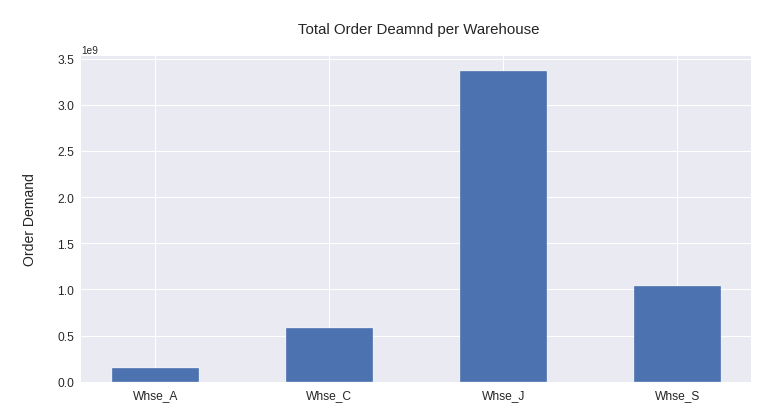

In [337]:
# Order Demand analysis
df_whse  = df
df_whse = df_whse.groupby(['Warehouse']).sum()

# plot the results
(fig, ax)= plt.subplots(figsize = (12,6))
plt.bar(x= df_whse.index, height= df_whse.Order_Demand, width=0.5)
ax.set_title('\n Total Order Deamnd per Warehouse\n', fontsize= 15)
ax.set_ylabel('\nOrder Demand\n',fontsize=14)
ax.tick_params(axis = 'x', labelsize= 12)
ax.tick_params(axis = 'y', labelsize= 12)

- The most important Warehouse interms of Order_Demand is 'Whse_J'.

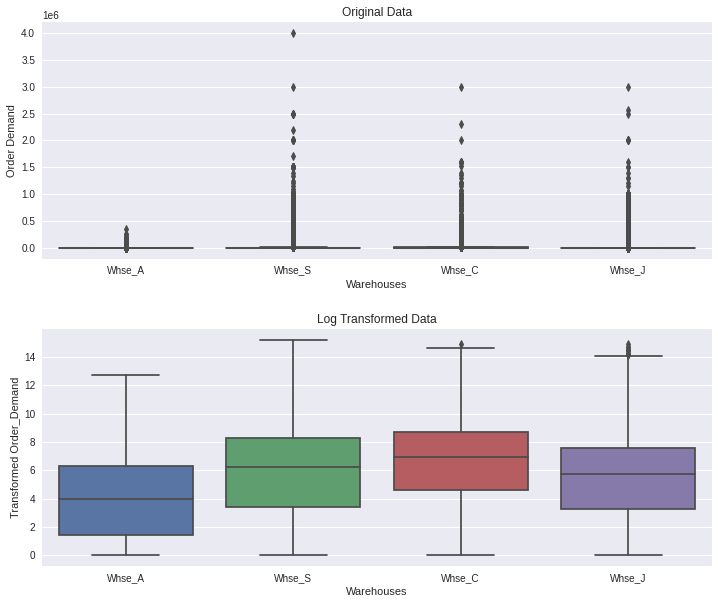

In [338]:
# Feature transformation ----> Log TRansformation
def warehouse_boxplot(df):
    rcParams['figure.figsize']=12,10
    fig, ax = plt.subplots(2,1)
    fig.subplots_adjust(hspace = 0.3)

    # original data
    fig1 = sns.boxplot(df['Warehouse'],df['Order_Demand'], ax = ax[0])
    ax[0].set_title('Original Data')
    ax[0].set_xlabel('Warehouses')
    ax[0].set_ylabel('Order Demand')

    # data after log transformation
    fig2 = sns.boxplot(df['Warehouse'],np.log1p(df['Order_Demand']), ax = ax[1])
    ax[1].set_title('Log Transformed Data')
    ax[1].set_xlabel('Warehouses')
    ax[1].set_ylabel('Transformed Order_Demand')

warehouse_boxplot(df)

- Now the Datapoints are normalized.

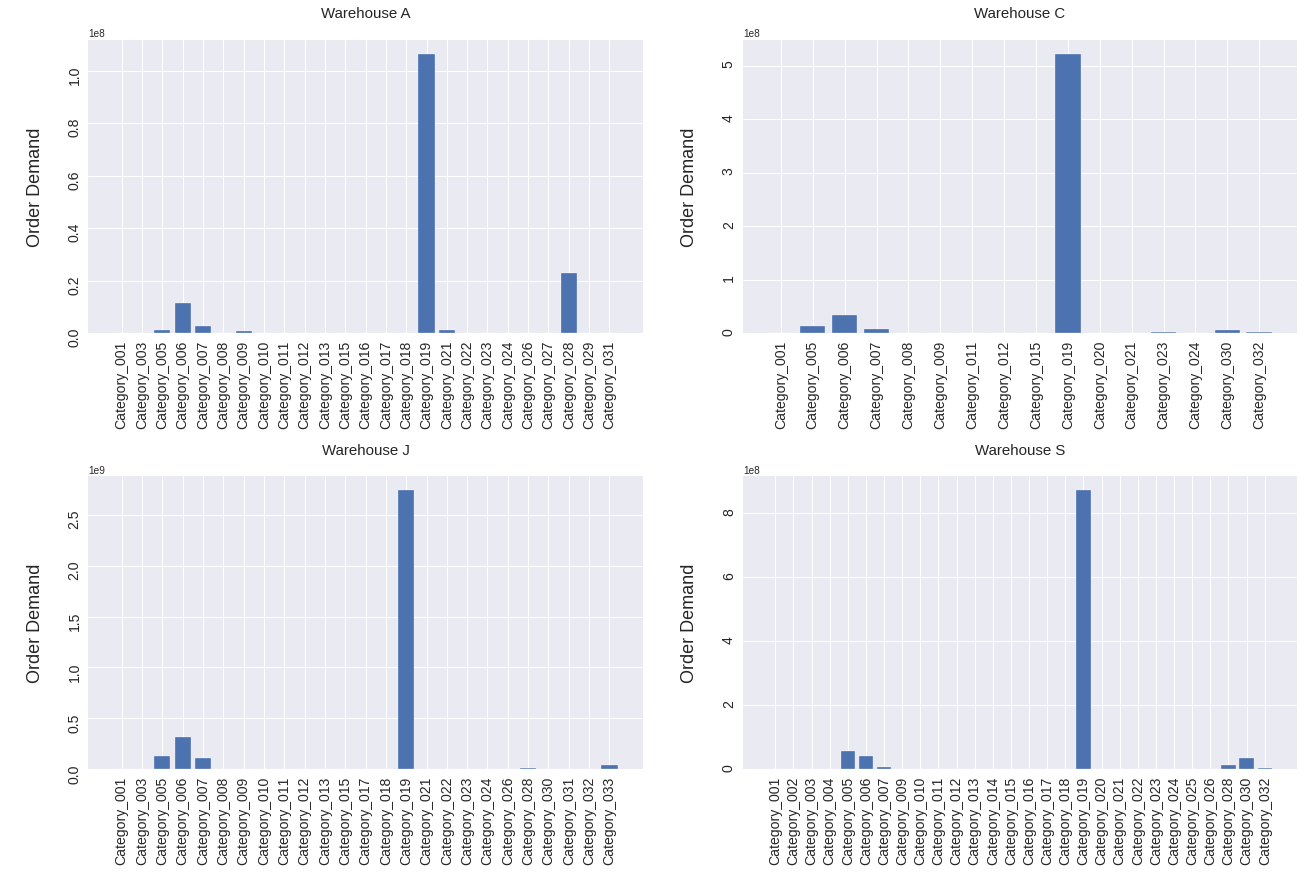

In [339]:
def order_demand_whse_procat(df, title, warehouse, ax):
    warehouse_cat = df.groupby(['Warehouse','Product_Category']).sum()
    # plot the results
    ax.bar(warehouse_cat.loc[warehouse]['Order_Demand'].index,
         warehouse_cat.loc[warehouse]['Order_Demand'])
    ax.set_title(title, fontsize= 15)
    ax.set_ylabel('\nOrder Demand\n',fontsize= 18)
    ax.tick_params(labelrotation=90)
    ax.tick_params(axis='x',labelsize=14)
    ax.tick_params(axis='y',labelsize=14)

# visualizing 
fig1, ((ax1,ax2),(ax3,ax4))= plt.subplots(nrows=2, ncols=2, figsize=(18,12), constrained_layout= True)
order_demand_whse_procat(df,'Warehouse A\n', 'Whse_A', ax1)
order_demand_whse_procat(df,'Warehouse C\n', 'Whse_C', ax2)
order_demand_whse_procat(df,'Warehouse J\n', 'Whse_J', ax3)
order_demand_whse_procat(df,'Warehouse S\n', 'Whse_S', ax4)

    



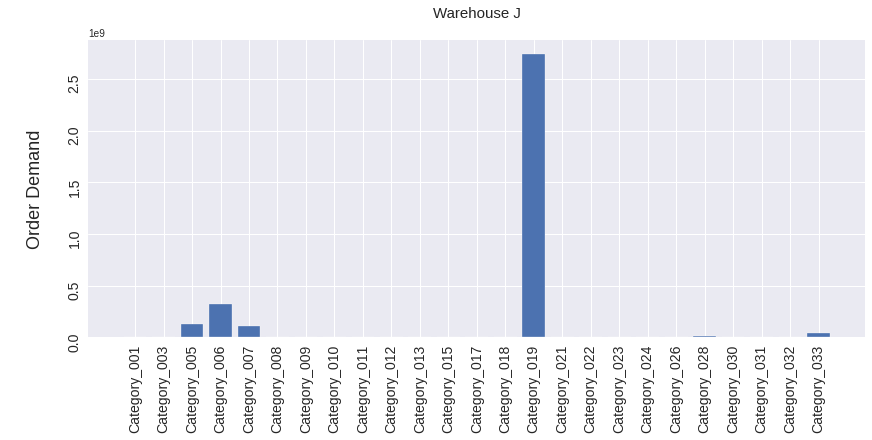

In [340]:
# to see clearly in Whse_J
fig, ax = plt.subplots(nrows= 1, ncols= 1, figsize= (12,6), constrained_layout= True)
order_demand_whse_procat(df,'Warehouse J\n', 'Whse_J', ax)

- By this, we can see that the most important Product Catogory in terms of Order_demand is 'Category_019'

         Product_Code Warehouse Product_Category       Date  Order_Demand
107159   Product_0138    Whse_J     Category_007 2011-11-22          1852
107158   Product_0138    Whse_J     Category_007 2011-11-22           188
93055    Product_0504    Whse_J     Category_015 2011-12-05             1
107170   Product_0138    Whse_J     Category_007 2011-12-05           240
37485    Product_1699    Whse_J     Category_026 2011-12-07             1
...               ...       ...              ...        ...           ...
920140   Product_0025    Whse_J     Category_005 2017-01-06           500
920154   Product_0025    Whse_J     Category_005 2017-01-06           700
920147   Product_1970    Whse_J     Category_005 2017-01-06          2000
1009604  Product_1710    Whse_J     Category_026 2017-01-06            15
921328   Product_1359    Whse_J     Category_019 2017-01-06        100000

[764447 rows x 5 columns]


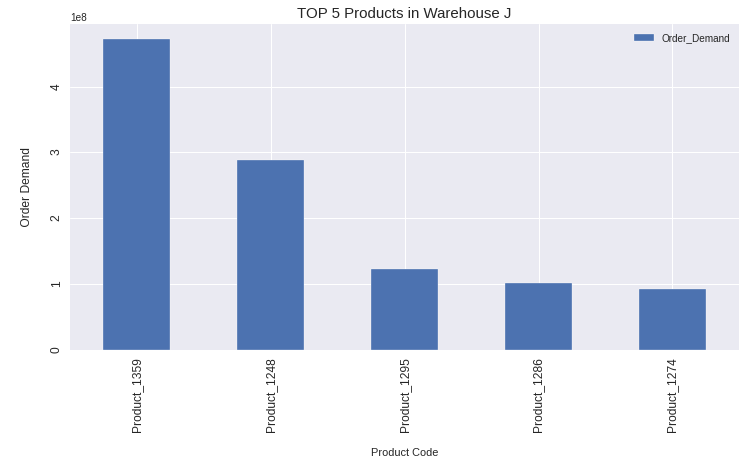

In [341]:
def order_demand_whse_procat_procode_top5(df, title):
    warehouse_product_demand_top5= df.groupby('Product_Code')['Order_Demand'].sum().sort_values(ascending=False).to_frame().head()
    # plot the results
    rcParams['figure.figsize']= 12,6
    ax = warehouse_product_demand_top5.plot.bar()
    ax.set_title(title, fontsize= 15)
    ax.set_xlabel('\n Product Code \n')
    ax.set_ylabel('\n Order Demand \n',fontsize= 12)
    ax.tick_params(labelrotation= 90)
    ax.tick_params(axis='x', labelsize= 12)
    ax.tick_params(axis='y', labelsize= 12)

df_Whse_J  = df[(df['Warehouse'] == 'Whse_J')]
print(df_Whse_J)

order_demand_whse_procat_procode_top5(df_Whse_J, 'TOP 5 Products in Warehouse J')  

- Choosing the Product_1359 in category_019 for forecasting as it is the most important product in with high demand.

# Demand Analysis - Yearly

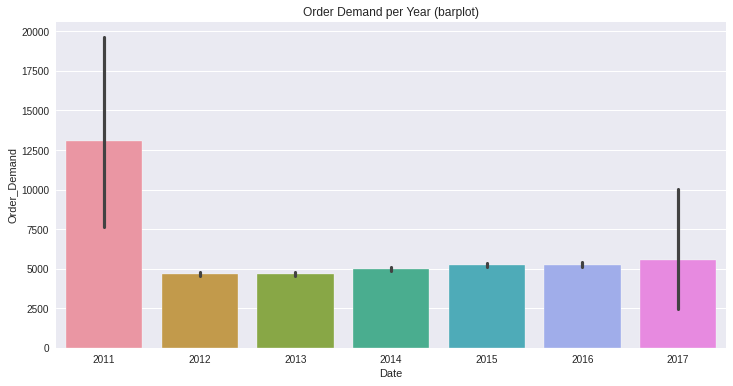

In [342]:
# barplot
rcParams['figure.figsize']= 12,6
sns.barplot(x= pd.DatetimeIndex(df['Date']).year, 
            y=df['Order_Demand'])
plt.title('Order Demand per Year (barplot)')
plt.show()


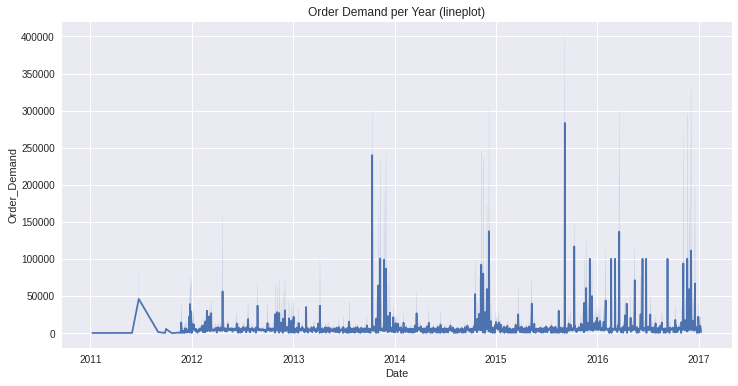

In [343]:
rcParams['figure.figsize']= 12,6
sns.lineplot(x= df['Date'], 
            y= df['Order_Demand'])
plt.title('Order Demand per Year (lineplot)')
plt.show()

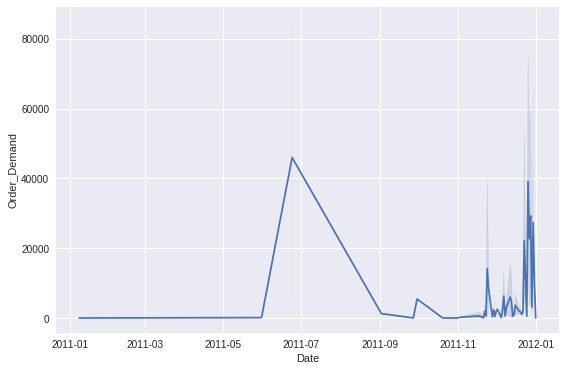

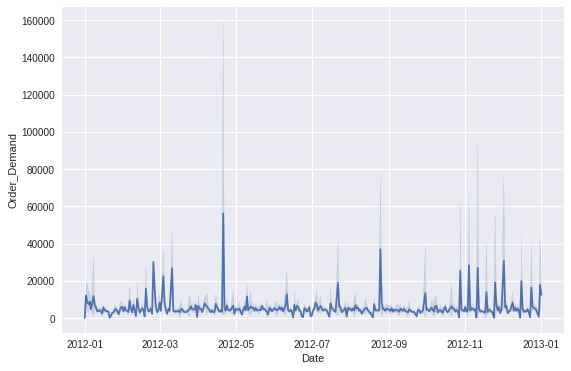

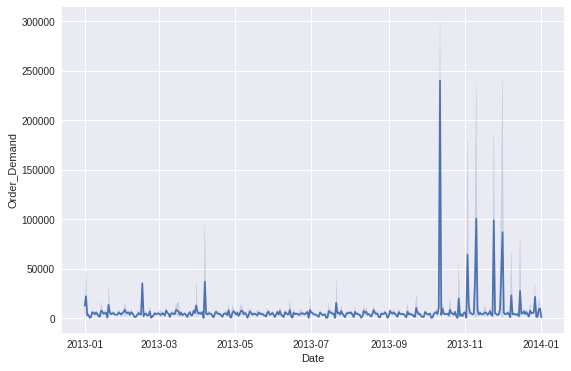

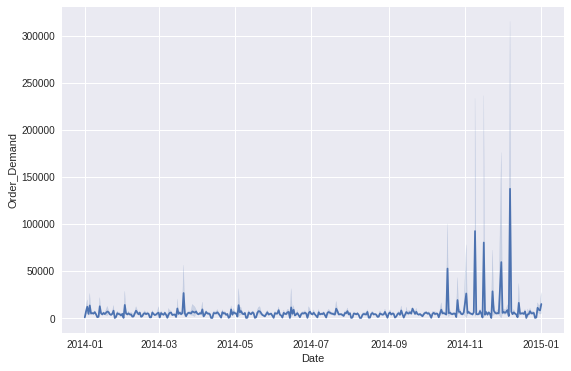

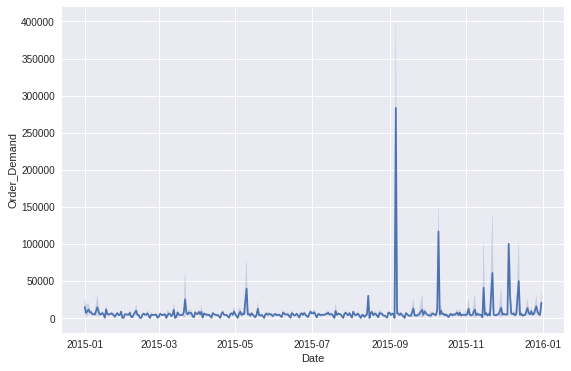

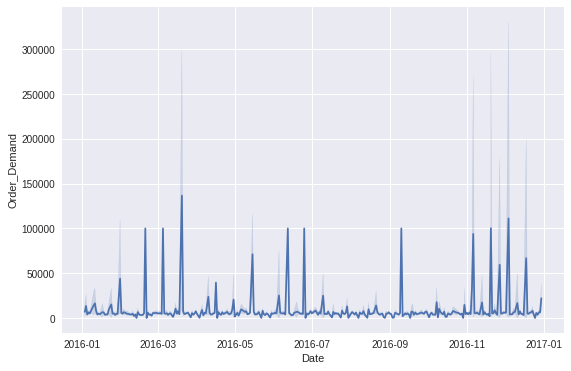

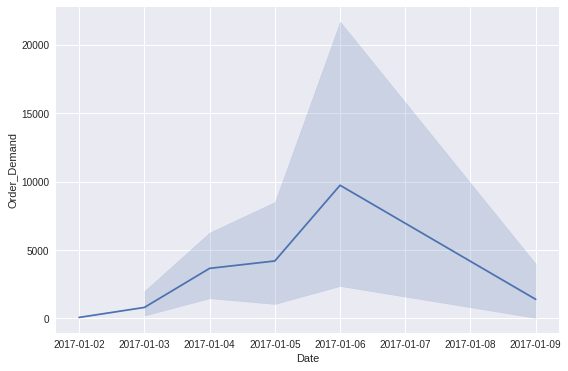

In [344]:
# DataFrame yearwise
def list_df(df):
    df_2011 = df[(df['Date']>='2011-01-01') & (df['Date']<='2012-01-01')].sort_values('Date',ascending = True).copy()
    df_2012 = df[(df['Date']>='2012-01-01') & (df['Date']<='2013-01-01')].sort_values('Date',ascending = True).copy()
    df_2013 = df[(df['Date']>='2013-01-01') & (df['Date']<='2014-01-01')].sort_values('Date',ascending = True).copy()
    df_2014 = df[(df['Date']>='2014-01-01') & (df['Date']<='2015-01-01')].sort_values('Date',ascending = True).copy()
    df_2015 = df[(df['Date']>='2015-01-01') & (df['Date']<='2016-01-01')].sort_values('Date',ascending = True).copy()
    df_2016 = df[(df['Date']>='2016-01-01') & (df['Date']<='2017-01-01')].sort_values('Date',ascending = True).copy()
    df_2017 = df[(df['Date']>='2017-01-01') & (df['Date']<='2018-01-01')].sort_values('Date',ascending = True).copy()
    list_df = [df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017]
    return list_df

#Visualing the Demand by year:
list_df_by_year = list_df(df)

def plot_demand_by_Year(lists_df):
        for i in range(0, len(lists_df)):   
            rcParams['figure.figsize'] = 9,6
            sns.lineplot(x= list_df_by_year[i]['Date'], y= list_df_by_year[i]['Order_Demand'])
            plt.show()

plot_demand_by_Year(list_df_by_year)


In [345]:
# Demand per year
def yearly_demand(df):
    df_year = pd.DataFrame()
    df['Year']= df['Date'].dt.year
    df_year['Demand']= df.groupby('Year')['Order_Demand'].sum()
    df_year['Orders']= df['Year'].value_counts()
    df_year['Demand per Order']= (df_year['Demand']/df_year['Orders']).round(decimals=2)
    return df_year.sort_index(ascending= True)

yearly_demand(df)

Demand  Orders  Demand per Order
Year                                      
2011     8363894     640          13068.58
2012   949259991  203635           4661.58
2013  1014087922  218298           4645.43
2014  1071178367  216404           4949.90
2015  1099398391  209661           5243.70
2016   991590399  188645           5256.38
2017      294967      53           5565.42

- we can see that there are only few records in the years 2011 and 2017. Both the years has unusual demand/poor data and so we can drop them.

In [346]:
# Adjusting Dates for Analysis
def adjusting_dates(df):
    df = df[(df['Date']>='2012-01-01')&(df['Date']<='2016-12-31')].sort_values('Date',ascending =True)
    dates1 =[ pd.to_datetime(date) for date in df['Date']]
    dates1.sort()
    print(f'Start Date: {dates1[0]}')
    print(f'End Date: {dates1[-1]}')
    no_of_days = dates1[-1]-dates1[0]
    print(f'Delta Date: {no_of_days}')
    return df

df = adjusting_dates(df)
df.head()

Start Date: 2012-01-01 00:00:00
End Date: 2016-12-30 00:00:00
Delta Date: 1825 days 00:00:00


Product_Code Warehouse Product_Category       Date  Order_Demand  Year
130870  Product_2166    Whse_S     Category_024 2012-01-01             2  2012
77217   Product_1343    Whse_S     Category_019 2012-01-02          5000  2012
77218   Product_1433    Whse_S     Category_019 2012-01-02          2000  2012
75883   Product_1432    Whse_S     Category_019 2012-01-02         30000  2012
75882   Product_1342    Whse_S     Category_019 2012-01-02         50000  2012

- Now the datapoints in 2011 and 2017 are dropped.

In [347]:
# Demand in warehouse by orders
def whse_demand(df):
    print('\n--- Demand in Warehouse by Orders ---\n')
    df_whse = pd.DataFrame()
    df_whse['Orders'] = df['Warehouse'].value_counts()
    df_whse['Demand'] = df.groupby('Warehouse')['Order_Demand'].sum()
    df_whse['Demand per Order'] =df_whse['Demand']/ df_whse['Orders']
    df_whse['Demand per Order'] =df_whse['Demand per Order'].round(decimals=2)
    return df_whse.sort_values('Orders', ascending= False)

df_whse= whse_demand(df)
df_whse



--- Demand in Warehouse by Orders ---



Orders      Demand  Demand per Order
Whse_J  764215  3362742530           4400.26
Whse_A  142197   147646550           1038.32
Whse_S   88024  1033121811          11736.82
Whse_C   42207   582004179          13789.28

- Warehouse J has more demand interms of orders.
- Warehouse A has less demand interms of orders.

In [348]:
# Demand in Warehouse per year
def whse_demand_yr(df):
    print('\n--- Demand in Warehouse per Year ---\n')
    df_whse1 = df[['Year', 'Warehouse', 'Order_Demand']].groupby(['Year','Warehouse'],as_index = False).count()
    df_whse1 = df_whse1.pivot(index = 'Year', columns =  'Warehouse', values = 'Order_Demand')
    df_whse1['Total'] = df_whse1.sum(axis = 1)
    return df_whse1
df_whse_yr = whse_demand_yr(df)
df_whse_yr


--- Demand in Warehouse per Year ---



Warehouse  Whse_A  Whse_C  Whse_J  Whse_S   Total
Year                                             
2012        28218    6889  150013   18515  203635
2013        33607    7934  156251   20506  218298
2014        28124    8187  157786   22307  216404
2015        26686    8963  153937   20075  209661
2016        25562   10234  146228    6621  188645

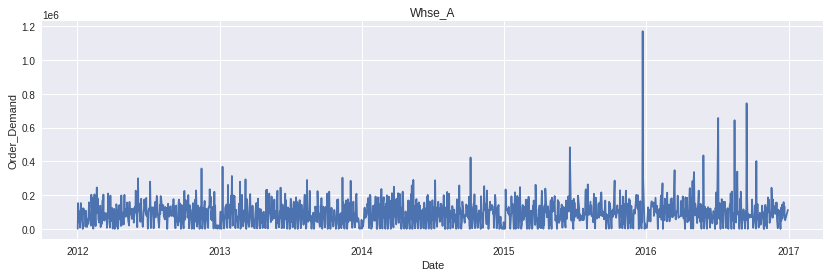

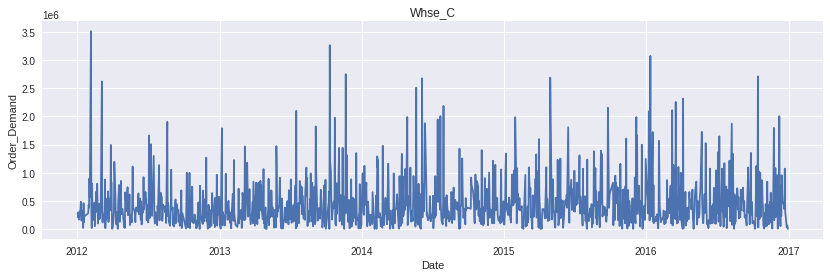

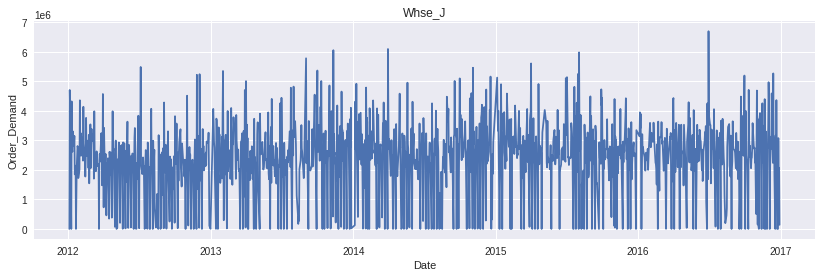

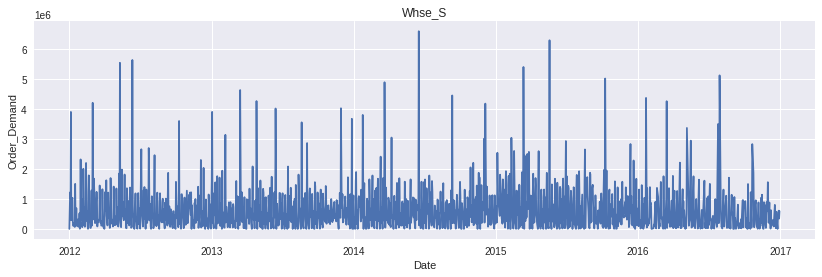

In [349]:
# Creating a Warehouse lists
def list_df_warehouse(df):
    df_warehouse2 = df[['Warehouse', 'Date', 'Order_Demand']].groupby(['Date', 'Warehouse'], as_index = False).sum()
    df_Whse_A= df_warehouse2[df_warehouse2['Warehouse']=='Whse_A']
    df_Whse_C = df_warehouse2[df_warehouse2['Warehouse']=='Whse_C']
    df_Whse_J = df_warehouse2[df_warehouse2['Warehouse']=='Whse_J']
    df_Whse_S = df_warehouse2[df_warehouse2['Warehouse']=='Whse_S']
    list_whse_df = [df_Whse_A, df_Whse_C, df_Whse_J, df_Whse_S]
    return list_whse_df

list_df_warehouse=list_df_warehouse(df)

# plotting the warehouse list
def plot_warehouse_data(list_whse_df):
    for i in range(0, len(list_whse_df)):
        rcParams['figure.figsize'] = 14,4
        sns.lineplot(x= list_df_warehouse[i]['Date'], y= list_df_warehouse[i]['Order_Demand']).set_title(list_df_warehouse[i]['Warehouse'].iloc[0])
        plt.show()
        print('')
        
plot_warehouse_data(list_df_warehouse)

In [350]:
df_whse_grpd = pd.concat(list_df_warehouse)
df_whse_grpd.sort_values(by= 'Date', inplace= True)
df_whse_grpd

Date Warehouse  Order_Demand
0    2012-01-01    Whse_S             2
1    2012-01-02    Whse_A           500
2    2012-01-02    Whse_S        679777
5    2012-01-03    Whse_S       1217228
4    2012-01-03    Whse_C        275137
...         ...       ...           ...
5806 2016-12-29    Whse_J        139046
5805 2016-12-29    Whse_C         45185
5809 2016-12-30    Whse_C             0
5808 2016-12-30    Whse_A        112770
5810 2016-12-30    Whse_S        590180

[5811 rows x 3 columns]

In [351]:
def df_whse_info(df):
    df_whse_pivot = pd.pivot_table(df, index = 'Date', columns= 'Warehouse', values= 'Order_Demand', fill_value=0)
    print('--- Data Info ---\n')
    print(df_whse_pivot.info())
    print('\n--- Demands Percentage ---\n')
    print((1- (df_whse_pivot.astype(bool).sum(axis = 0) / df_whse_pivot.count(axis = 0)))*100)
    print('\n--- Dataset Pivoted by Date')
    return df_whse_pivot

df_whse_info(df_whse_grpd)

--- Data Info ---

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1681 entries, 2012-01-01 to 2016-12-30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Whse_A  1681 non-null   int64
 1   Whse_C  1681 non-null   int64
 2   Whse_J  1681 non-null   int64
 3   Whse_S  1681 non-null   int64
dtypes: int64(4)
memory usage: 65.7 KB
None

--- Demands Percentage ---

Warehouse
Whse_A     8.209399
Whse_C    21.713266
Whse_J    19.393218
Whse_S     7.674004
dtype: float64

--- Dataset Pivoted by Date


Warehouse   Whse_A  Whse_C   Whse_J   Whse_S
Date                                        
2012-01-01       0       0        0        2
2012-01-02     500       0        0   679777
2012-01-03  152892  275137        0  1217228
2012-01-04   69163  204000      120  1022578
2012-01-05   38834  298318  4701940  3902682
...            ...     ...      ...      ...
2016-12-26       0  110600  3073044   444726
2016-12-27       0   27000  1215751   431475
2016-12-28       0   62910  2068312   609080
2016-12-29       0   45185   139046   346256
2016-12-30  112770       0        0   590180

[1681 rows x 4 columns]

# Order Demand Daywise

In [352]:
# Analyzing the Demand in Daywise
def demandby_date(df):
    demandby_date = df.groupby('Date')['Order_Demand'].sum().reset_index().copy()
    # indexing the date
    demandby_date = demandby_date.set_index('Date').copy()
    print('--- Demand per Day info ---\n')
    print(demandby_date.index)
    print('\n--- Data of Demand per day ---\n')
    return demandby_date

demandby_date_df = demandby_date(df)

demandby_date_df

--- Demand per Day info ---

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

--- Data of Demand per day ---



Order_Demand
Date                    
2012-01-01             2
2012-01-02        680277
2012-01-03       1645257
2012-01-04       1295861
2012-01-05       8941774
...                  ...
2016-12-26       3628370
2016-12-27       1674226
2016-12-28       2740302
2016-12-29        530487
2016-12-30        702950

[1681 rows x 1 columns]

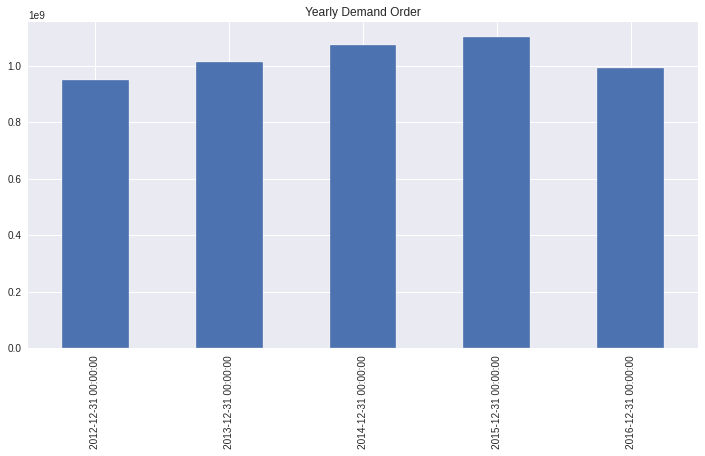

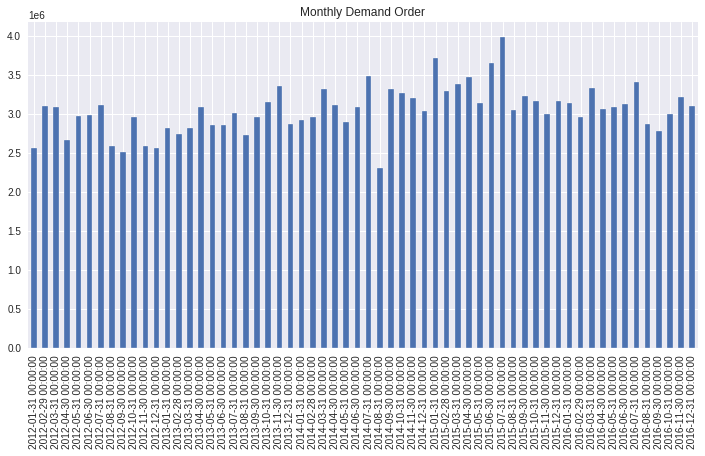

In [353]:
# Analyzing the Demand yearwise
def demandby_year_month(df):
    fig1 = df['Order_Demand'].resample('A').sum().plot.bar(figsize = (12,6))
    fig1.set_title('Yearly Demand Order')
    fig1.set_xlabel('')
    plt.show()
    print('\n')
    fig2 = demandby_date_df['Order_Demand'].resample('M').mean().plot.bar(figsize= (12,6))
    fig2.set_title('Monthly Demand Order')
    fig2.set_xlabel('')
    plt.show()

demandby_year_month(demandby_date_df)

# Decomposition 

In [354]:
def y_period(df, periods):
    y_list = []
    for item in periods:
        y_period = df['Order_Demand'].resample(item).mean()
        y_list.append(y_period)
    return y_list

        

In [355]:
# check for null values
periods = ['B', 'W', 'M']
y_periods = y_period(demandby_date_df, periods)

for i in range(len(y_periods)):
    if i == 0:
        y_daily = y_periods[i]
        print(f'Null Values for daily Time Series : {y_daily.isna().sum()}')
    elif i == 1:
        y_weekly = y_periods[i]
        print(f'Null Values for Weekly Time series : {y_weekly.isna().sum()}')
    else:
        y_monthly  = y_periods[i]

        print(f'Null Values for Monthly Time series : {y_monthly.isna().sum()}')



Null Values for daily Time Series : 0
Null Values for Weekly Time series : 0
Null Values for Monthly Time series : 0


In [356]:
def plot_period(y_period, w_period1, w_period2):
    plt.rcParams['figure.figsize'] = 12,6
    plt.plot(y_period, label= 'period')
    plt.plot(y_period.rolling(window = w_period1).mean(),label= f'{w_period1} period(s) mean')
    plt.plot(y_period.rolling(window = w_period2).mean(),label= f'{w_period2} period(s) mean')
    plt.legend(loc= 'best')


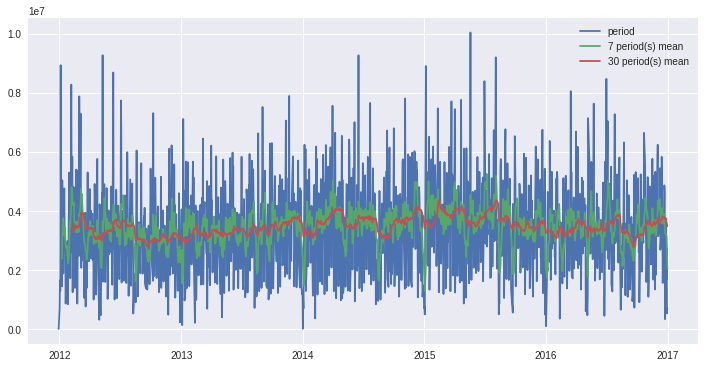

In [357]:
plot_period(y_daily, 7, 30)

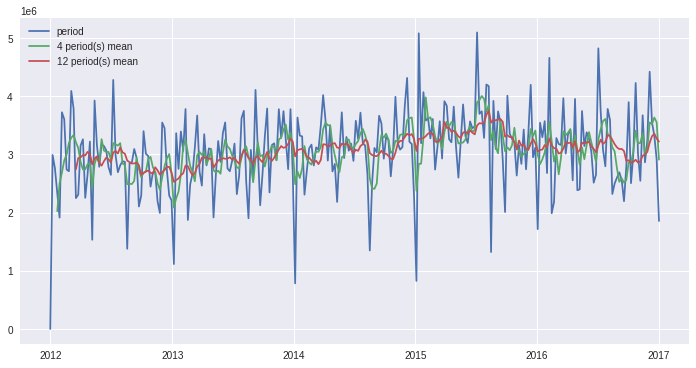

In [358]:
plot_period(y_weekly, 4, 12)

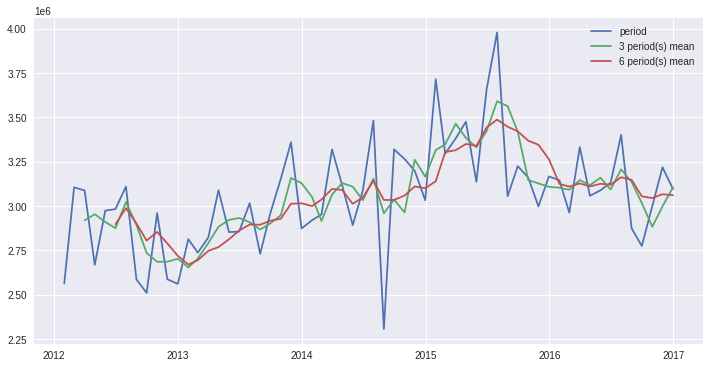

In [359]:
plot_period(y_monthly, 3, 6)

In [360]:
def plt_seasonal(res, ax):
    res.observed.plot(ax= ax[0], legend= False)
    ax[0].set_ylabel('Observed')
    res.trend.plot(ax= ax[1], legend= False)
    ax[1].set_ylabel('Trend')
    res.seasonal.plot(ax= ax[2], legend= False)
    ax[2].set_ylabel('Seasonal')
    res.resid.plot(ax= ax[3], legend= False)
    ax[3].set_ylabel('Residual')

In [361]:
def plt_seasonal_decomp(dec_day, dec_week, dec_month):
    fig, ax = plt.subplots(ncols= 3, nrows= 4, sharex= True, figsize= (18,9))
    ax[0,0].set_title('Daily', pad= 21)
    ax[0,1].set_title('Weekly', pad= 21)
    ax[0,2].set_title('Monthly', pad= 21)
    plt_seasonal(dec_day, ax[:,0])
    plt_seasonal(dec_week, ax[:,1])
    plt_seasonal(dec_month, ax[:,2])
    plt.tight_layout()
    plt.show()

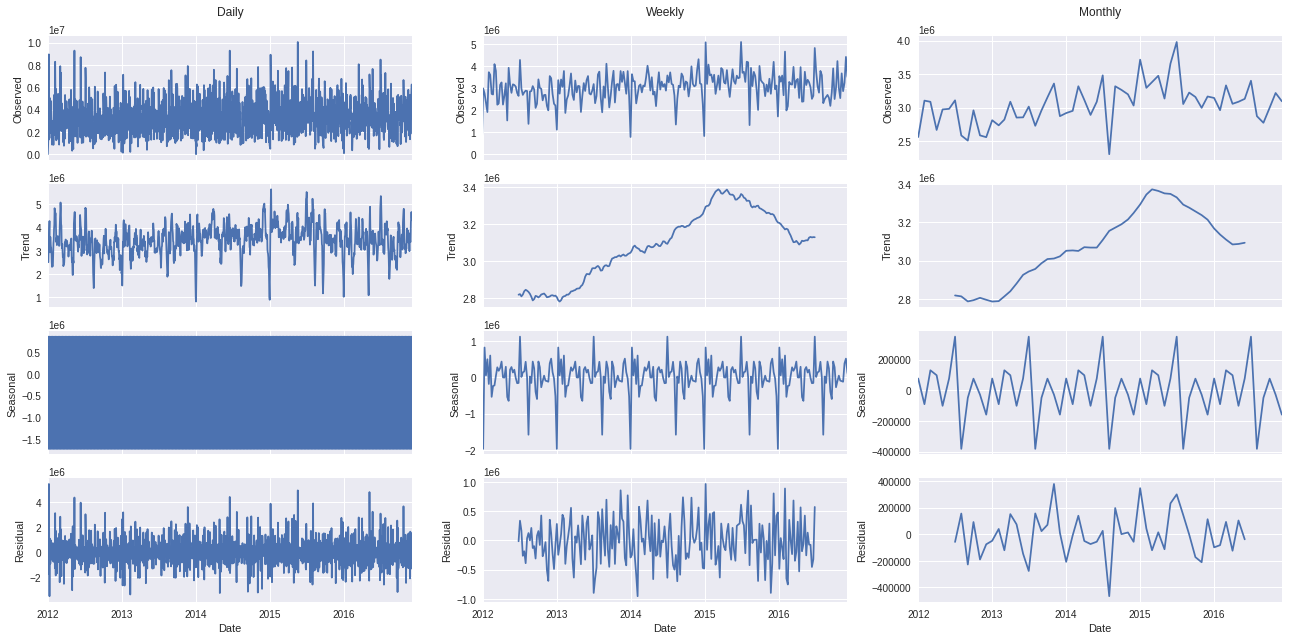

In [362]:
decomp_daily= sm.tsa.seasonal_decompose(y_daily, model= 'additive')
decomp_weekly= sm.tsa.seasonal_decompose(y_weekly, model= 'additive')
decomp_monthly= sm.tsa.seasonal_decompose(y_monthly, model= 'additive')
plt_seasonal_decomp(decomp_daily, decomp_weekly, decomp_monthly)


# Moving Average & Exponential Smoothening 

In [363]:
# Smothening Technique using Exponential Moving Window
def sm_exp_win(df, window1, window2, span1, span2):
    y= pd.DataFrame(df).copy()
    y.dropna(inplace= True)
    y.index = pd.to_datetime(df.index)
    y['Window1'] = y['Order_Demand'].rolling(window= window1).mean()
    y['Window2'] = y['Order_Demand'].rolling(window= window2).mean()
    y['Span1'] = y['Order_Demand'].ewm(span= span1).mean().shift(-1)
    y['Span2'] = y['Order_Demand'].ewm(span= span2).mean().shift(-1)
    return y['Window1'], y['Window2'] ,y['Span1'], y['Span2']

### MA & Exp Smoothening - Daily

In [364]:
y_d  = pd.DataFrame(y_daily).copy()
y_d['7_daily_SMA'] = sm_exp_win(y_daily, 7, 30, 3, 6)[0]
y_d['30_daily_SMA'] = sm_exp_win(y_daily, 7, 30, 3, 6)[1]
y_d['3_span_daily_exp_win'] = sm_exp_win(y_daily, 7, 30, 3, 6)[2]
y_d['6_span_daily_exp_win'] = sm_exp_win(y_daily, 7, 30, 3, 6)[3]

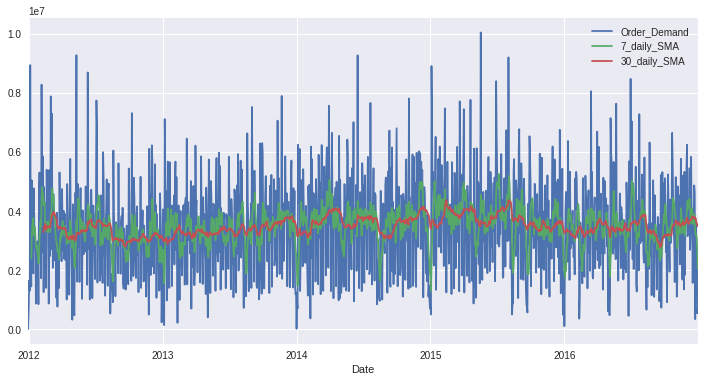

In [365]:
y_d[['Order_Demand', '7_daily_SMA', '30_daily_SMA']].plot()

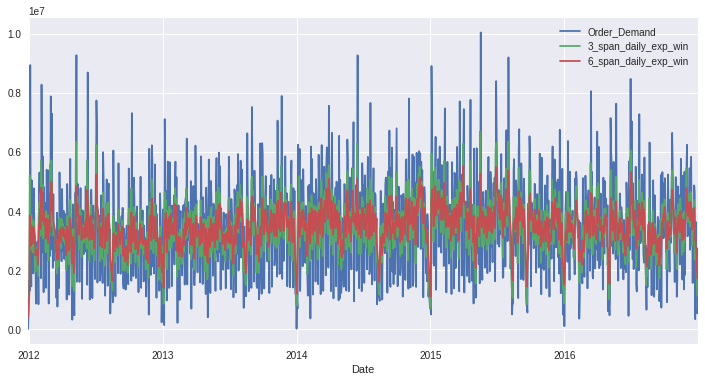

In [366]:
y_d[['Order_Demand', '3_span_daily_exp_win', '6_span_daily_exp_win']].plot()

In [367]:
y_d['SIMPLExpSmooth_level06'] = SimpleExpSmoothing(y_d['Order_Demand'], initialization_method= 'heuristic').fit(smoothing_level=0.6, optimized= False).fittedvalues
y_d['SIMPLExpSmooth_estimated'] = SimpleExpSmoothing(y_d['Order_Demand'], initialization_method= 'estimated').fit().fittedvalues
y_d['ExpSmooth_trend_add'] = ExponentialSmoothing(y_d['Order_Demand'], trend= 'add').fit().fittedvalues


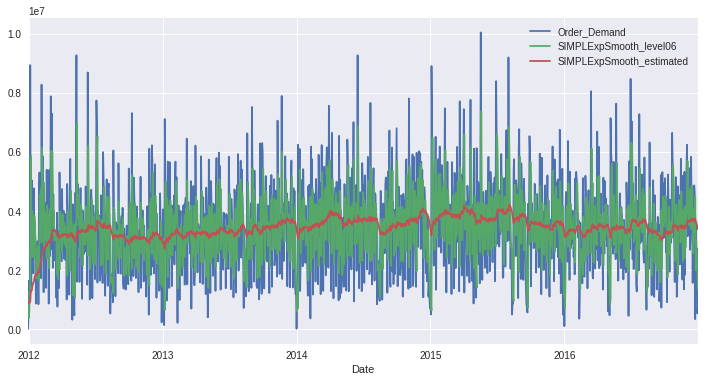

In [368]:
y_d[['Order_Demand', 'SIMPLExpSmooth_level06','SIMPLExpSmooth_estimated']].plot()

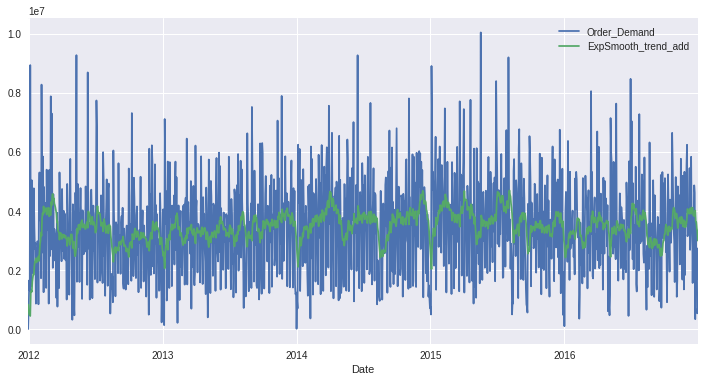

In [369]:
y_d[['Order_Demand', 'ExpSmooth_trend_add']].plot()

### MA & Exp Smoothening - Weekly

In [370]:
y_w = pd.DataFrame(y_weekly).copy()
y_w['4_weeek_sma']= sm_exp_win(y_weekly, 4, 12, 3, 6)[0]
y_w['12_week_sma']= sm_exp_win(y_weekly, 4, 12, 3, 6)[1]
y_w['3_span_ewma']= sm_exp_win(y_weekly, 4, 12, 3, 6)[2]
y_w['6_span_ewma']= sm_exp_win(y_weekly, 4, 12, 3, 6)[3]


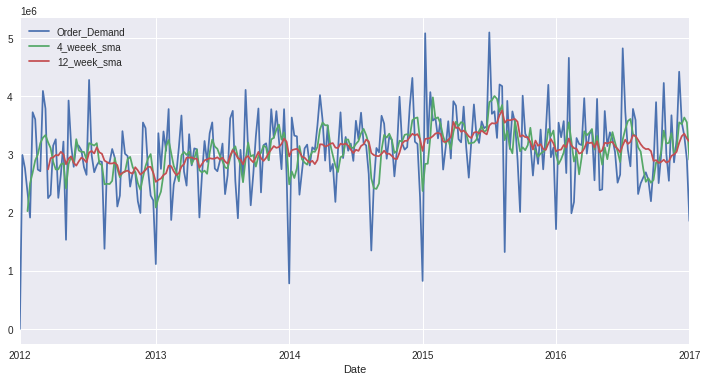

In [371]:
y_w[['Order_Demand', '4_weeek_sma', '12_week_sma']].plot()

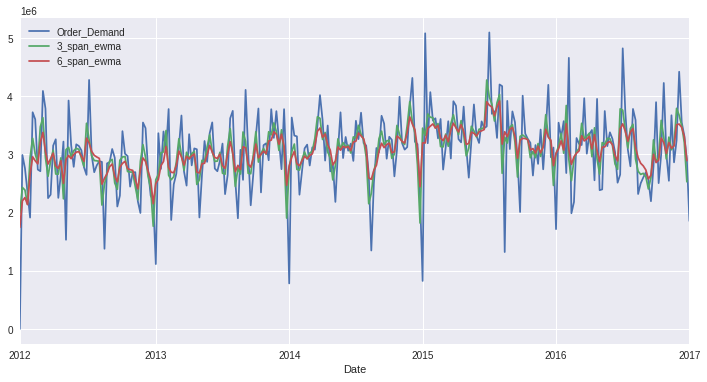

In [372]:
y_w[['Order_Demand', '3_span_ewma', '6_span_ewma']].plot();


In [373]:
y_w['SIMPLExpSmooth_level06'] = SimpleExpSmoothing(y_w['Order_Demand'], initialization_method='heuristic').fit(smoothing_level=0.6, optimized=False).fittedvalues
y_w['SIMPLExpSmooth_estimated'] = SimpleExpSmoothing(y_w['Order_Demand'], initialization_method="estimated").fit().fittedvalues
y_w['ExpSmooth_trend_add'] = ExponentialSmoothing(y_w['Order_Demand'], trend='add').fit().fittedvalues


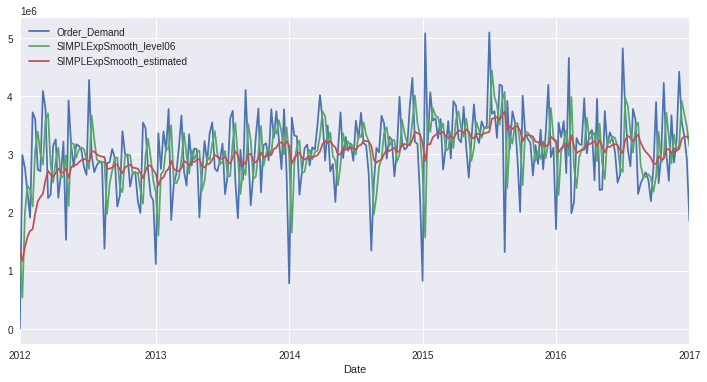

In [374]:
y_w[['Order_Demand', 'SIMPLExpSmooth_level06', 'SIMPLExpSmooth_estimated']].plot();


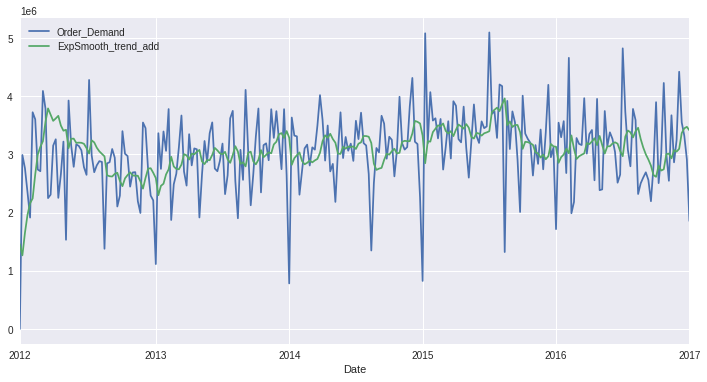

In [375]:
y_w[['Order_Demand', 'ExpSmooth_trend_add']].plot();


### MA & Exp Smoothening - Weekly

In [376]:
y_m = pd.DataFrame(y_monthly).copy()
y_m['3_month_sma'] =  sm_exp_win(y_monthly, 3, 6, 3, 6)[0]
y_m['6_month_sma'] = sm_exp_win(y_monthly, 3, 6, 3, 6)[1]
y_m['3_span_ewma'] = sm_exp_win(y_monthly, 3, 6, 3, 6)[2]
y_m['6_span_ewma'] = sm_exp_win(y_monthly, 3, 6, 3, 6)[3]


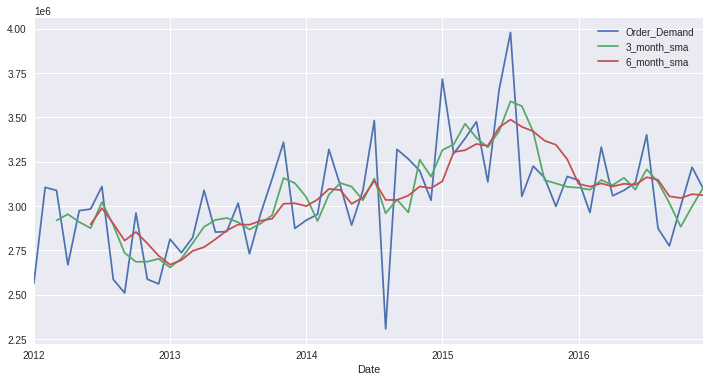

In [377]:
y_m[['Order_Demand', '3_month_sma', '6_month_sma']].plot();


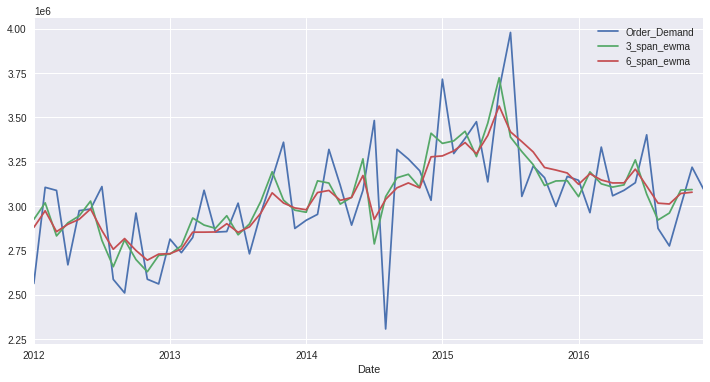

In [378]:
y_m[['Order_Demand', '3_span_ewma', '6_span_ewma']].plot();


In [379]:
y_m['SIMPLExpSmooth_level06'] = SimpleExpSmoothing(y_m['Order_Demand'], initialization_method='heuristic').fit(smoothing_level=0.6, optimized=False).fittedvalues
y_m['SIMPLExpSmooth_estimated'] = SimpleExpSmoothing(y_m['Order_Demand'], initialization_method="estimated").fit().fittedvalues
y_m['ExpSmooth_trend_add'] = ExponentialSmoothing(y_m['Order_Demand'], trend='add').fit().fittedvalues
y_m['ExpSmooth_trend_mul'] = ExponentialSmoothing(y_m['Order_Demand'], trend='mul').fit().fittedvalues
y_m['ExpSmooth_trend_mul_seasmul12'] = ExponentialSmoothing(y_m['Order_Demand'], trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues


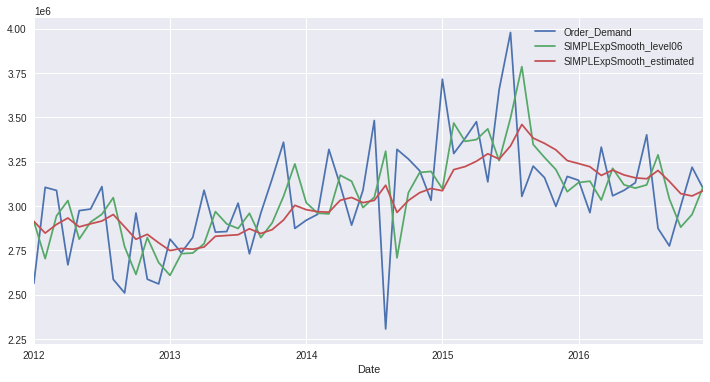

In [380]:
y_m[['Order_Demand', 'SIMPLExpSmooth_level06', 'SIMPLExpSmooth_estimated']].plot();


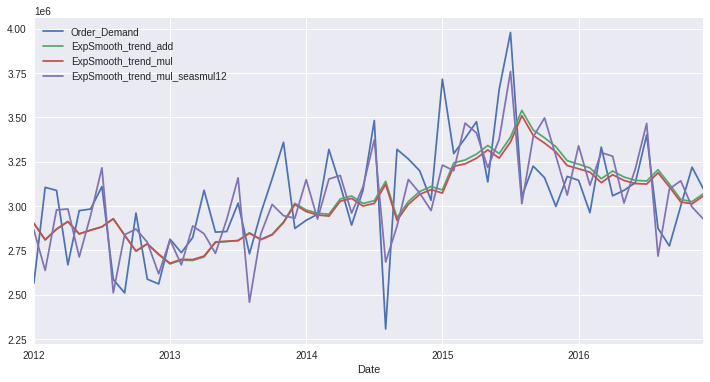

In [381]:
y_m[['Order_Demand', 'ExpSmooth_trend_add', 'ExpSmooth_trend_mul', 'ExpSmooth_trend_mul_seasmul12']].plot();


# Stationarity Check - Augmented Dickey Fuller Test

In [382]:
def stationarity_check(ts_data):
    # Determining rolling statistics
    roll_mean= ts_data.rolling(12).mean()
    roll_std= ts_data.rolling(12).std()

    # plot the rolling statistics
    orig= plt.plot(ts_data, label= 'Original Data')
    mean= plt.plot(roll_mean, label= 'Rolling Mean')
    std= plt.plot(roll_std, label= 'Rolling Std')
    plt.rcParams['figure.figsize'] = (12,6)
    plt.legend(loc= 'best')
    plt.title('Rolling Mean & Standard Deviation ')
    plt.show()

    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test: ')
    adf_test = adfuller(ts_data.dropna(), autolag= 'AIC')
    adf_output = pd.Series(adf_test[0:4], index= ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' %key] = value
    print(adf_output.to_string())

    if adf_test[1] <= 0.05:
        print('The p-value is < 0.05')
        print('Reject the Null Hypothesis ')
        print('Data has no unit root and is stationary')
    else:
        print('The p-value is > 0.05')
        print('Accept the Null Hypothesis ')
        print('Data has a unit root and is non-stationary')




### Stationarity Check - Daily

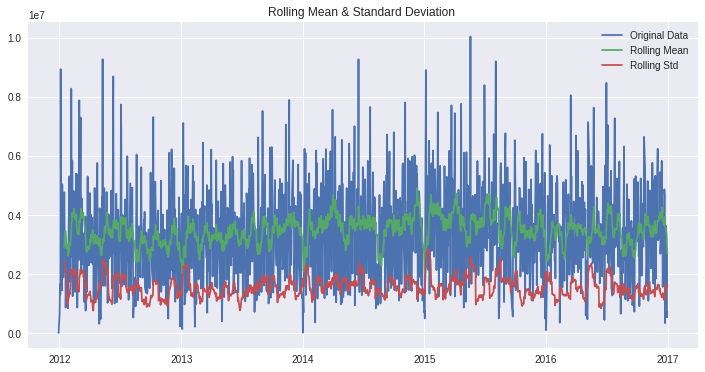

Results of Dickey-Fuller Test: 
Test Statistic               -6.732774e+00
p-value                       3.264119e-09
#Lags Used                    1.900000e+01
Number of Observation Used    1.286000e+03
Critical Value (1%)          -3.435445e+00
Critical Value (5%)          -2.863790e+00
Critical Value (10%)         -2.567968e+00
The p-value is < 0.05
Reject the Null Hypothesis 
Data has no unit root and is stationary


In [383]:
stationarity_check(y_daily)

### Stationarity Check - Daily

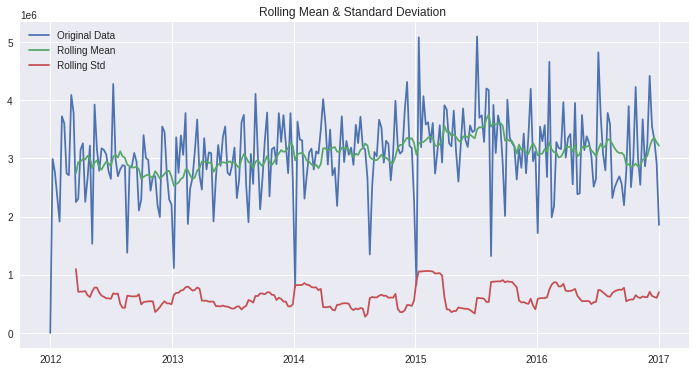

Results of Dickey-Fuller Test: 
Test Statistic               -1.571275e+01
p-value                       1.353249e-28
#Lags Used                    0.000000e+00
Number of Observation Used    2.610000e+02
Critical Value (1%)          -3.455656e+00
Critical Value (5%)          -2.872678e+00
Critical Value (10%)         -2.572705e+00
The p-value is < 0.05
Reject the Null Hypothesis 
Data has no unit root and is stationary


In [384]:
stationarity_check(y_weekly)

### Stationarity Check - Daily

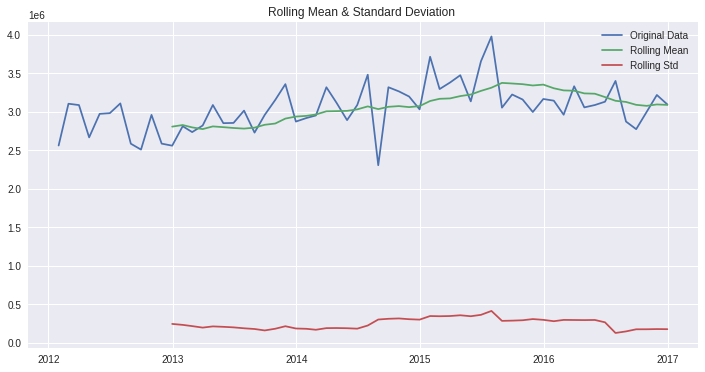

Results of Dickey-Fuller Test: 
Test Statistic                -1.690040
p-value                        0.436251
#Lags Used                     3.000000
Number of Observation Used    56.000000
Critical Value (1%)           -3.552928
Critical Value (5%)           -2.914731
Critical Value (10%)          -2.595137
The p-value is > 0.05
Accept the Null Hypothesis 
Data has a unit root and is non-stationary


In [385]:
stationarity_check(y_monthly)

## Lag Plot

- A lag plot is a special type of scatter plot with the two variables (X,Y) “lagged.” A “lag” is a fixed amount of passing time; One set of observations in a time series is plotted (lagged) against a second, later set of data. The kth lag is the time period that happened “k” time points before time i.

In [386]:
def lagplot(df, lag= 8):
    plt.rcParams['figure.figsize'] = 12,6
    for i in range(1,(lag+1)):
        ax = plt.subplot(240+i)
        lag_plot(df, lag= i)
    plt.show()

### Lagplot - Daily

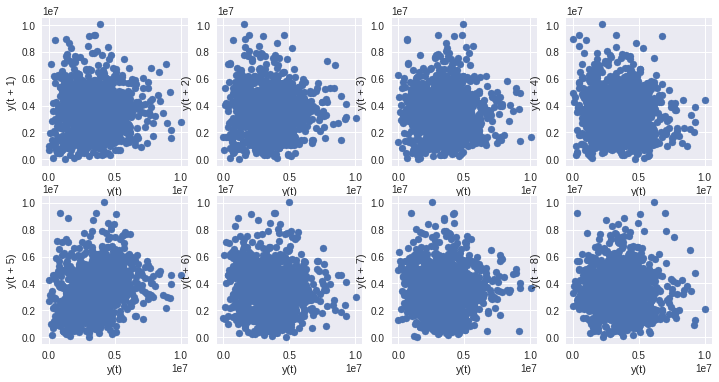

In [387]:
lagplot(y_daily)


### Lagplot - Weekly

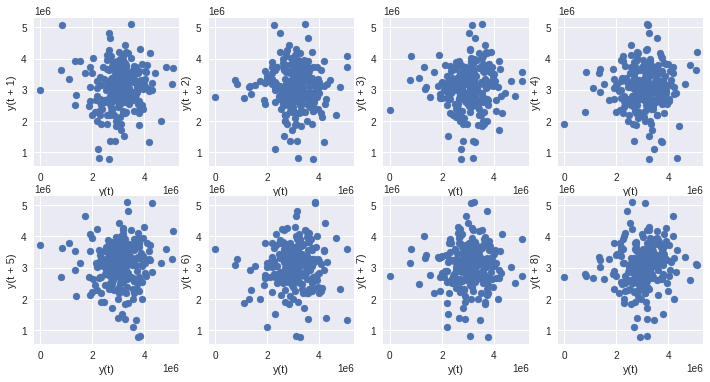

In [388]:
lagplot(y_weekly)


### Lagplot - Monthly

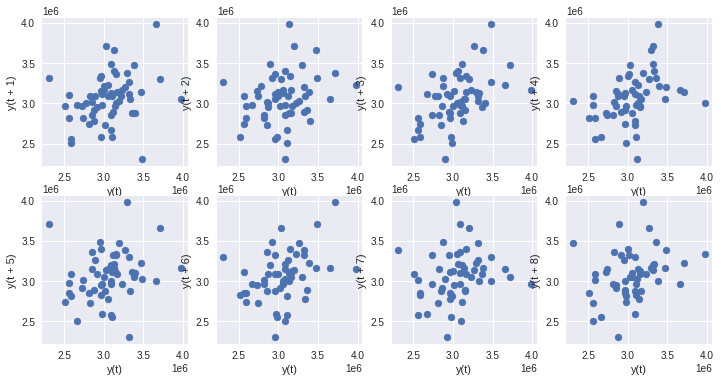

In [389]:
lagplot(y_monthly)


## AutoCorrelation and Partial AutoCorrelation Plots - Daily

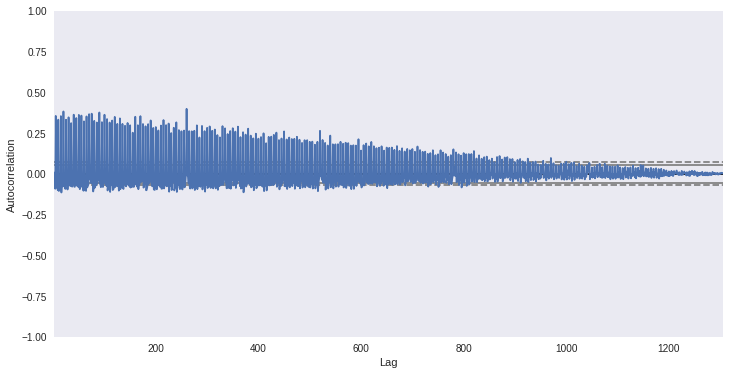

In [390]:
autocorrelation_plot(y_daily)

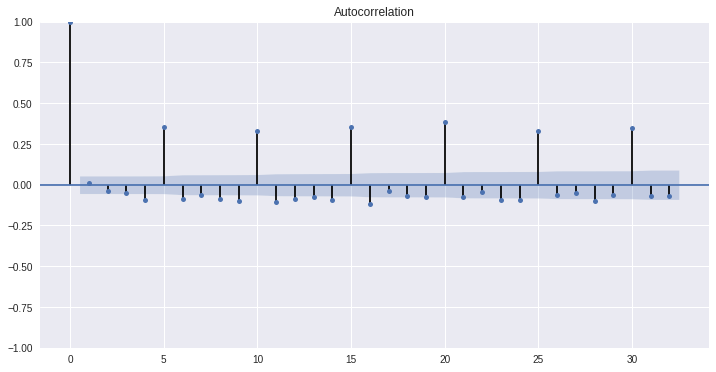

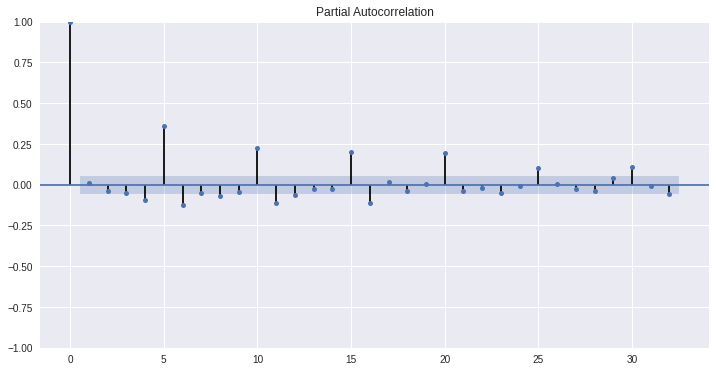

In [391]:
plot_acf(y_daily), plot_pacf(y_daily)
plt.show()

### AutoCorrelation and Partial AutoCorrelation Plots - Weekly

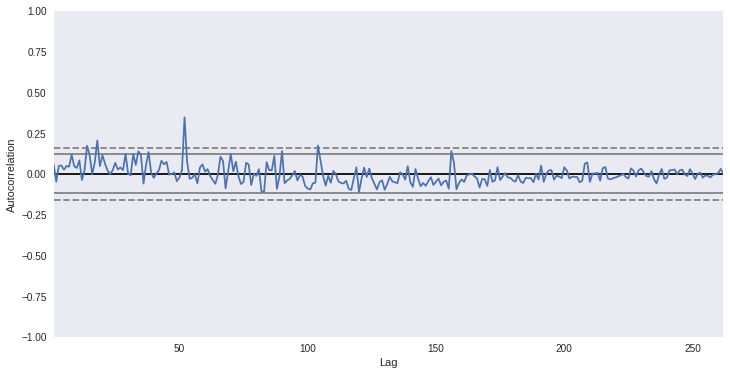

In [392]:
autocorrelation_plot(y_weekly)

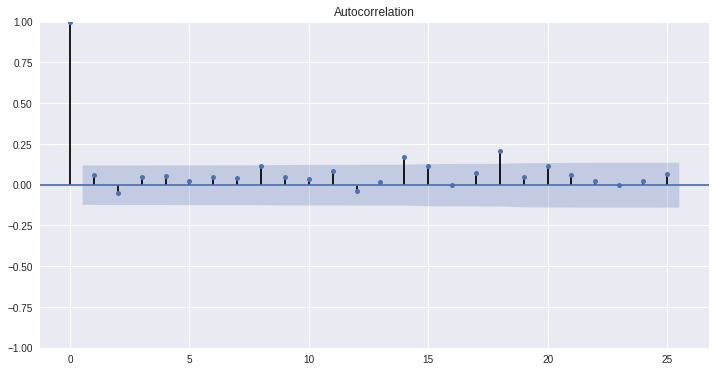

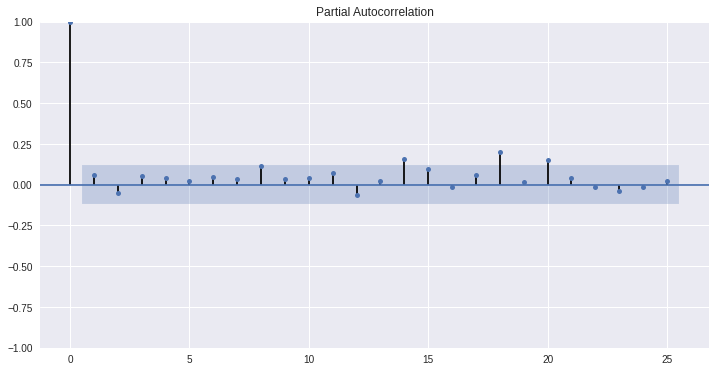

In [393]:
plot_acf(y_weekly), plot_pacf(y_weekly)
plt.show()

### AutoCorrelation and Partial AutoCorrelation Plots - Monthly

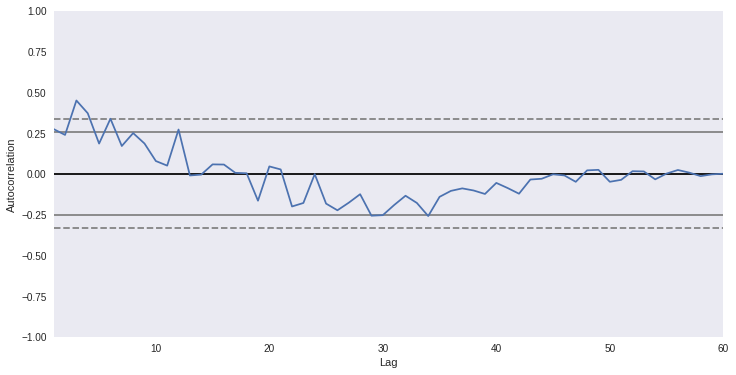

In [394]:
autocorrelation_plot(y_monthly)

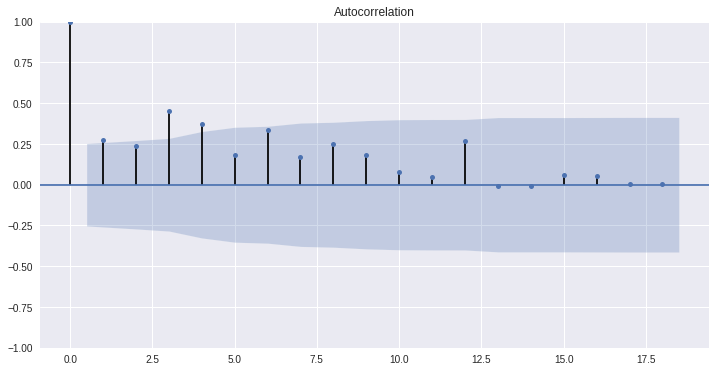

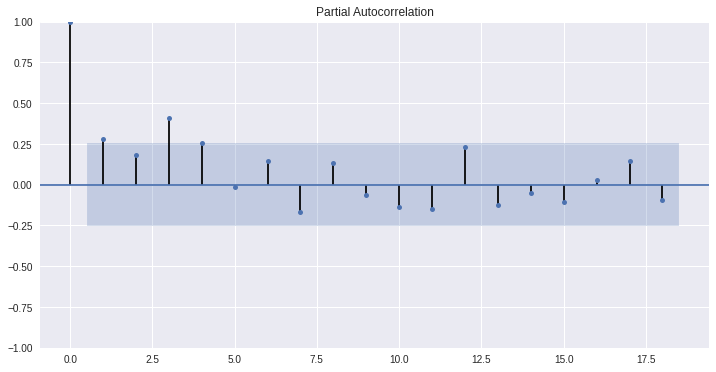

In [395]:
plot_acf(y_monthly), plot_pacf(y_monthly)
plt.show()

# Choosen the Product (Product_1359) for Forecasting

In [396]:
warehouses_products_demand = pd.DataFrame(df.groupby('Product_Code')['Order_Demand'].sum().sort_values(ascending=False))
warehouses_products_demand

Order_Demand
Product_Code              
Product_1359     472374000
Product_1248     289117000
Product_0083     210651000
Product_1341     166411000
Product_1295     123303000
...                    ...
Product_0638            22
Product_0853            20
Product_0465             3
Product_1698             2
Product_1703             2

[2160 rows x 1 columns]

In [397]:
chosen_product = df[df['Product_Code']=='Product_1359']
chosen_product = chosen_product.reset_index(drop=True)

chosen_product

Product_Code Warehouse Product_Category       Date  Order_Demand  Year
0      Product_1359    Whse_J     Category_019 2012-01-05         50000  2012
1      Product_1359    Whse_J     Category_019 2012-01-05          5000  2012
2      Product_1359    Whse_J     Category_019 2012-01-05          5000  2012
3      Product_1359    Whse_J     Category_019 2012-01-05          2000  2012
4      Product_1359    Whse_J     Category_019 2012-01-05        300000  2012
...             ...       ...              ...        ...           ...   ...
16930  Product_1359    Whse_J     Category_019 2016-12-28          3000  2016
16931  Product_1359    Whse_J     Category_019 2016-12-28         13000  2016
16932  Product_1359    Whse_J     Category_019 2016-12-28         10000  2016
16933  Product_1359    Whse_J     Category_019 2016-12-28          3000  2016
16934  Product_1359    Whse_J     Category_019 2016-12-28         11000  2016

[16935 rows x 6 columns]

In [398]:
chosen_product['Year'] = chosen_product['Date'].dt.year
chosen_product['Quarter'] = chosen_product['Date'].dt.quarter
chosen_product['Month'] = chosen_product['Date'].dt.month
chosen_product['Week'] = chosen_product['Date'].dt.week
chosen_product['Day'] = chosen_product['Date'].dt.day
chosen_product


Product_Code Warehouse Product_Category       Date  Order_Demand  Year  \
0      Product_1359    Whse_J     Category_019 2012-01-05         50000  2012   
1      Product_1359    Whse_J     Category_019 2012-01-05          5000  2012   
2      Product_1359    Whse_J     Category_019 2012-01-05          5000  2012   
3      Product_1359    Whse_J     Category_019 2012-01-05          2000  2012   
4      Product_1359    Whse_J     Category_019 2012-01-05        300000  2012   
...             ...       ...              ...        ...           ...   ...   
16930  Product_1359    Whse_J     Category_019 2016-12-28          3000  2016   
16931  Product_1359    Whse_J     Category_019 2016-12-28         13000  2016   
16932  Product_1359    Whse_J     Category_019 2016-12-28         10000  2016   
16933  Product_1359    Whse_J     Category_019 2016-12-28          3000  2016   
16934  Product_1359    Whse_J     Category_019 2016-12-28         11000  2016   

       Quarter  Month  Week  Day  
0            1      1     1    5  
1            1      1     1    5  
2            1      1     1    5  
3            1      1     1    5  
4            1      1     1    5  
...        ...    ...   ...  ...  
16930        4     12    52   28  
16931        4     12    52   28  
16932        4     12    52   28  
16933        4     12    52   28  
16934        4     12    52   28  

[16935 rows x 10 columns]

In [399]:
chosen_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16935 entries, 0 to 16934
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Product_Code      16935 non-null  object        
 1   Warehouse         16935 non-null  object        
 2   Product_Category  16935 non-null  object        
 3   Date              16935 non-null  datetime64[ns]
 4   Order_Demand      16935 non-null  int64         
 5   Year              16935 non-null  int64         
 6   Quarter           16935 non-null  int64         
 7   Month             16935 non-null  int64         
 8   Week              16935 non-null  int64         
 9   Day               16935 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(3)
memory usage: 1.3+ MB


In [400]:
chosen_product['YearQuarter'] = chosen_product.apply(lambda x: str(x['Year'])+'-'+str(x['Quarter']), axis=1)
chosen_product


Product_Code Warehouse Product_Category       Date  Order_Demand  Year  \
0      Product_1359    Whse_J     Category_019 2012-01-05         50000  2012   
1      Product_1359    Whse_J     Category_019 2012-01-05          5000  2012   
2      Product_1359    Whse_J     Category_019 2012-01-05          5000  2012   
3      Product_1359    Whse_J     Category_019 2012-01-05          2000  2012   
4      Product_1359    Whse_J     Category_019 2012-01-05        300000  2012   
...             ...       ...              ...        ...           ...   ...   
16930  Product_1359    Whse_J     Category_019 2016-12-28          3000  2016   
16931  Product_1359    Whse_J     Category_019 2016-12-28         13000  2016   
16932  Product_1359    Whse_J     Category_019 2016-12-28         10000  2016   
16933  Product_1359    Whse_J     Category_019 2016-12-28          3000  2016   
16934  Product_1359    Whse_J     Category_019 2016-12-28         11000  2016   

       Quarter  Month  Week  Day YearQuarter  
0            1      1     1    5      2012-1  
1            1      1     1    5      2012-1  
2            1      1     1    5      2012-1  
3            1      1     1    5      2012-1  
4            1      1     1    5      2012-1  
...        ...    ...   ...  ...         ...  
16930        4     12    52   28      2016-4  
16931        4     12    52   28      2016-4  
16932        4     12    52   28      2016-4  
16933        4     12    52   28      2016-4  
16934        4     12    52   28      2016-4  

[16935 rows x 11 columns]

In [401]:
chosen_product['Product_Code'] = chosen_product['Product_Code'].apply(lambda x: x.strip('Product_'))
chosen_product['Product_Category'] = chosen_product['Product_Category'].apply(lambda x: x.strip('Category_'))
chosen_product['Product_Code'] = chosen_product['Product_Code'].astype(int)
chosen_product['Product_Category'] = chosen_product['Product_Category'].astype(int)
chosen_product


Product_Code Warehouse  Product_Category       Date  Order_Demand  \
0              1359    Whse_J                19 2012-01-05         50000   
1              1359    Whse_J                19 2012-01-05          5000   
2              1359    Whse_J                19 2012-01-05          5000   
3              1359    Whse_J                19 2012-01-05          2000   
4              1359    Whse_J                19 2012-01-05        300000   
...             ...       ...               ...        ...           ...   
16930          1359    Whse_J                19 2016-12-28          3000   
16931          1359    Whse_J                19 2016-12-28         13000   
16932          1359    Whse_J                19 2016-12-28         10000   
16933          1359    Whse_J                19 2016-12-28          3000   
16934          1359    Whse_J                19 2016-12-28         11000   

       Year  Quarter  Month  Week  Day YearQuarter  
0      2012        1      1     1    5      2012-1  
1      2012        1      1     1    5      2012-1  
2      2012        1      1     1    5      2012-1  
3      2012        1      1     1    5      2012-1  
4      2012        1      1     1    5      2012-1  
...     ...      ...    ...   ...  ...         ...  
16930  2016        4     12    52   28      2016-4  
16931  2016        4     12    52   28      2016-4  
16932  2016        4     12    52   28      2016-4  
16933  2016        4     12    52   28      2016-4  
16934  2016        4     12    52   28      2016-4  

[16935 rows x 11 columns]

In [402]:
chosen_product['YearMonth'] = chosen_product['Date'].apply(lambda x: x.strftime('%Y-%m'))
chosen_product


Product_Code Warehouse  Product_Category       Date  Order_Demand  \
0              1359    Whse_J                19 2012-01-05         50000   
1              1359    Whse_J                19 2012-01-05          5000   
2              1359    Whse_J                19 2012-01-05          5000   
3              1359    Whse_J                19 2012-01-05          2000   
4              1359    Whse_J                19 2012-01-05        300000   
...             ...       ...               ...        ...           ...   
16930          1359    Whse_J                19 2016-12-28          3000   
16931          1359    Whse_J                19 2016-12-28         13000   
16932          1359    Whse_J                19 2016-12-28         10000   
16933          1359    Whse_J                19 2016-12-28          3000   
16934          1359    Whse_J                19 2016-12-28         11000   

       Year  Quarter  Month  Week  Day YearQuarter YearMonth  
0      2012        1      1     1    5      2012-1   2012-01  
1      2012        1      1     1    5      2012-1   2012-01  
2      2012        1      1     1    5      2012-1   2012-01  
3      2012        1      1     1    5      2012-1   2012-01  
4      2012        1      1     1    5      2012-1   2012-01  
...     ...      ...    ...   ...  ...         ...       ...  
16930  2016        4     12    52   28      2016-4   2016-12  
16931  2016        4     12    52   28      2016-4   2016-12  
16932  2016        4     12    52   28      2016-4   2016-12  
16933  2016        4     12    52   28      2016-4   2016-12  
16934  2016        4     12    52   28      2016-4   2016-12  

[16935 rows x 12 columns]

In [403]:
chosen_product['DayWeek'] = [i.dayofweek for i in chosen_product['Date']]
chosen_product


Product_Code Warehouse  Product_Category       Date  Order_Demand  \
0              1359    Whse_J                19 2012-01-05         50000   
1              1359    Whse_J                19 2012-01-05          5000   
2              1359    Whse_J                19 2012-01-05          5000   
3              1359    Whse_J                19 2012-01-05          2000   
4              1359    Whse_J                19 2012-01-05        300000   
...             ...       ...               ...        ...           ...   
16930          1359    Whse_J                19 2016-12-28          3000   
16931          1359    Whse_J                19 2016-12-28         13000   
16932          1359    Whse_J                19 2016-12-28         10000   
16933          1359    Whse_J                19 2016-12-28          3000   
16934          1359    Whse_J                19 2016-12-28         11000   

       Year  Quarter  Month  Week  Day YearQuarter YearMonth  DayWeek  
0      2012        1      1     1    5      2012-1   2012-01        3  
1      2012        1      1     1    5      2012-1   2012-01        3  
2      2012        1      1     1    5      2012-1   2012-01        3  
3      2012        1      1     1    5      2012-1   2012-01        3  
4      2012        1      1     1    5      2012-1   2012-01        3  
...     ...      ...    ...   ...  ...         ...       ...      ...  
16930  2016        4     12    52   28      2016-4   2016-12        2  
16931  2016        4     12    52   28      2016-4   2016-12        2  
16932  2016        4     12    52   28      2016-4   2016-12        2  
16933  2016        4     12    52   28      2016-4   2016-12        2  
16934  2016        4     12    52   28      2016-4   2016-12        2  

[16935 rows x 13 columns]

### Product-1359 Demand Analysis

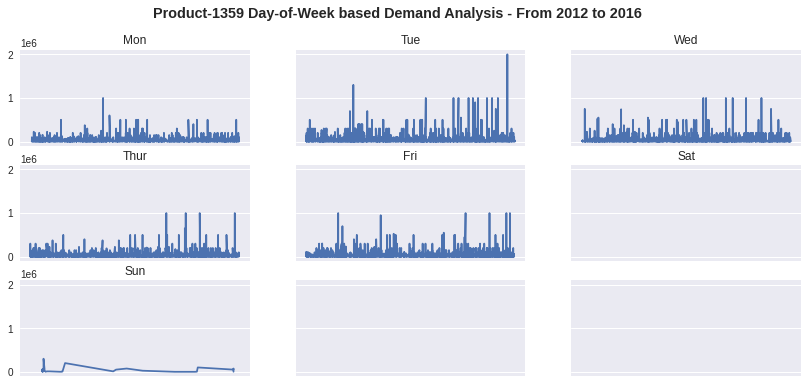

In [404]:
fig, ax= plt.subplots(nrows= 3, ncols= 3, figsize= (14,6), sharey= True, sharex= True)
days= ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
for day in range(7):
    chosen_product [chosen_product ['DayWeek'] == day].plot (y = 'Order_Demand', ax = ax [day // 3, day % 3], legend = False, title = days [day])
plt.suptitle ('Product-1359 Day-of-Week based Demand Analysis - From 2012 to 2016', fontweight = 'bold', fontsize = 'x-large')
plt.xticks ([])
plt.show ()


- Tuesday has better Demand 
- Sunday has very Poor Demand 
- Saturday has no Demand

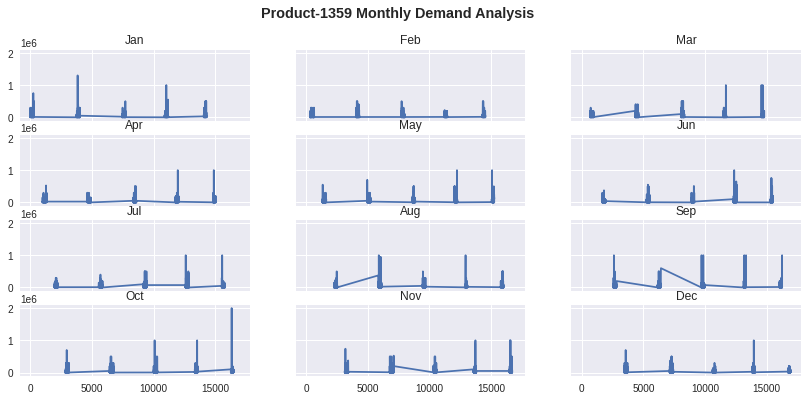

In [405]:
print('\n')
fig, ax = plt.subplots (nrows = 4, ncols = 3, figsize = (14, 6), sharey = True, sharex = True)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for month in range (1, 13):
    chosen_product [chosen_product ['Month'] == month]. plot (y = 'Order_Demand', ax = ax [(month - 1) // 3, (month - 1) % 3], legend = False, title = months [month - 1])
plt.suptitle ('Product-1359 Monthly Demand Analysis', fontweight = 'bold', fontsize = 'x-large')
plt.show ()

In [406]:
temp = pd.pivot_table(chosen_product, values='Order_Demand', index=['Date'], columns=['Product_Code'], aggfunc=np.sum).fillna(0)
temp.columns = list(temp.columns)
temp


1359
Date              
2012-01-05  702000
2012-01-06  676000
2012-01-10  783000
2012-01-11  200000
2012-01-12  284000
...            ...
2016-12-21  284000
2016-12-22  180000
2016-12-26  286000
2016-12-27   90000
2016-12-28  140000

[1231 rows x 1 columns]

In [407]:
columns= ['Date','Order_Demand']
temp_df = chosen_product.groupby(columns).count().reset_index().fillna(0)[columns]
temp_df.set_index('Date', inplace = True)
temp_df_grouped = temp_df.groupby(by='index', level='Date').sum()
temp_df_grouped

Order_Demand
Date                    
2012-01-05        659000
2012-01-06        567000
2012-01-10        633000
2012-01-11        113000
2012-01-12        183000
...                  ...
2016-12-21        215000
2016-12-22        165000
2016-12-26        277000
2016-12-27         39000
2016-12-28         87000

[1231 rows x 1 columns]

In [408]:
temp_df_complete = temp_df_grouped.asfreq('d', fill_value=0)
temp_df_complete['Order_Demand'] = temp_df_complete['Order_Demand'].astype(float)
temp_df_complete.head(10)


Order_Demand
Date                    
2012-01-05      659000.0
2012-01-06      567000.0
2012-01-07           0.0
2012-01-08           0.0
2012-01-09           0.0
2012-01-10      633000.0
2012-01-11      113000.0
2012-01-12      183000.0
2012-01-13      350000.0
2012-01-14           0.0

- This the dataset which is going to be used for predicting the Order_Demand for the product-1359

In [409]:
temp_week = chosen_product
temp_week['Date'] = pd.to_datetime(chosen_product['Date']) - pd.to_timedelta(0, unit='d')
temp_week = temp_week.groupby(['Product_Code', pd.Grouper(key='Date', freq='W-MON')])['Order_Demand'].sum().reset_index().sort_values('Date')
temp_df_complete_week = temp_week[['Date', 'Order_Demand']].set_index('Date')
temp_df_complete_week.drop(temp_df_complete_week.tail(1).index,inplace=True)
temp_df_complete_week


Order_Demand
Date                    
2012-01-09       1378000
2012-01-16       2278000
2012-01-23       1388000
2012-01-30       2468000
2012-02-06       3090000
...                  ...
2016-11-28       1699000
2016-12-05       1297000
2016-12-12       1502000
2016-12-19       2046000
2016-12-26       1078000

[259 rows x 1 columns]

In [410]:
temp_month = chosen_product
temp_month['Date'] = pd.to_datetime(chosen_product['Date']) - pd.to_timedelta(0, unit='m')
temp_month = temp_month.groupby(['Product_Code', pd.Grouper(key='Date', freq='M')])['Order_Demand'].sum().reset_index().sort_values('Date')
temp_df_complete_month = temp_month[['Date', 'Order_Demand']].set_index('Date')
temp_df_complete_month.drop(temp_df_complete_month.tail(1).index,inplace=True)
temp_df_complete_month


Order_Demand
Date                    
2012-01-31       8911000
2012-02-29       8131000
2012-03-31       7775000
2012-04-30       8960000
2012-05-31       8475000
2012-06-30       6556000
2012-07-31       7422000
2012-08-31       6667000
2012-09-30       8349000
2012-10-31       7685000
2012-11-30       7894000
2012-12-31       8302000
2013-01-31       9460000
2013-02-28       8216000
2013-03-31       8025000
2013-04-30       7902000
2013-05-31       8041000
2013-06-30       8324000
2013-07-31       7578000
2013-08-31       8732000
2013-09-30       7590000
2013-10-31       9626000
2013-11-30      10450000
2013-12-31       8748000
2014-01-31       7788000
2014-02-28       7818000
2014-03-31       9189000
2014-04-30       7864000
2014-05-31       8530000
2014-06-30       7055000
2014-07-31       9022000
2014-08-31       5763000
2014-09-30       7838000
2014-10-31       9750000
2014-11-30       8306000
2014-12-31       6198000
2015-01-31      10127000
2015-02-28       5298000
2015-03-31       7533000
2015-04-30       9015000
2015-05-31       7674000
2015-06-30       8521000
2015-07-31       8301000
2015-08-31       6475000
2015-09-30       8325000
2015-10-31       7794000
2015-11-30       7216000
2015-12-31       6803000
2016-01-31       7339000
2016-02-29       7196000
2016-03-31       7556000
2016-04-30       6341000
2016-05-31       6854000
2016-06-30       7870000
2016-07-31       7108000
2016-08-31       6934000
2016-09-30       6960000
2016-10-31       7727000
2016-11-30       8814000

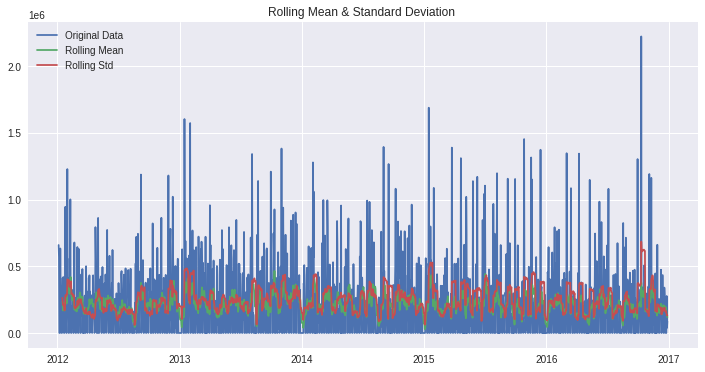

Results of Dickey-Fuller Test: 
Test Statistic               -1.072761e+01
p-value                       3.036990e-19
#Lags Used                    2.500000e+01
Number of Observation Used    1.794000e+03
Critical Value (1%)          -3.434000e+00
Critical Value (5%)          -2.863152e+00
Critical Value (10%)         -2.567628e+00
The p-value is < 0.05
Reject the Null Hypothesis 
Data has no unit root and is stationary


In [411]:
stationarity_check(temp_df_complete)


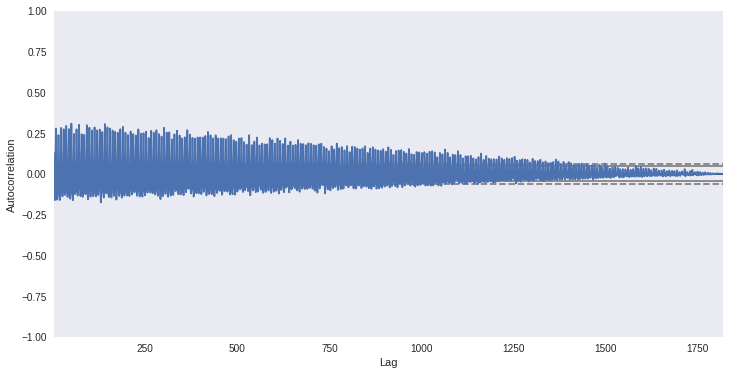

In [412]:
autocorrelation_plot(temp_df_complete);


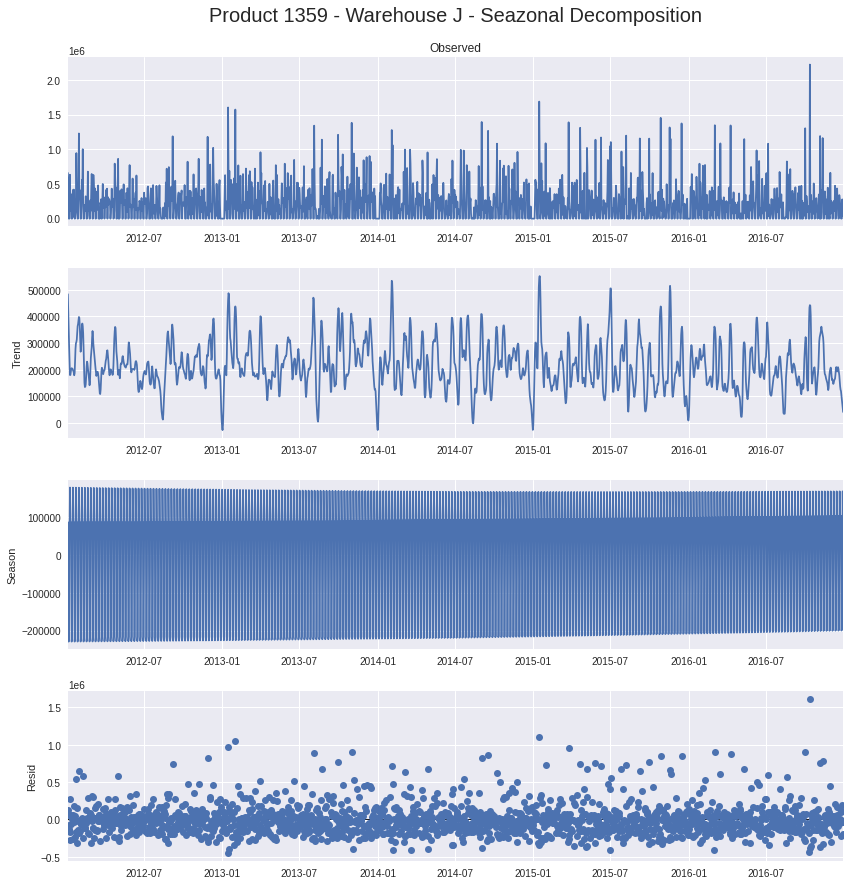

In [413]:
register_matplotlib_converters() # Register pandas formatters and converters with matplotlib.
                                        # This function modifies the global matplotlib.units.registry
                                        # dictionary. pandas adds custom converters for

plt.style.use('seaborn')
plt.rc("axes.spines", top=False, bottom = False, right=False, left=False)
plt.rc('font', size=13)
plt.rc('figure',figsize=(12,12))

stl = STL(temp_df_complete, seasonal=365)
res = stl.fit()
res.plot()    
plt.title('Product 1359 - Warehouse J - Seazonal Decomposition', fontsize = 20, pad=670)
plt.show()

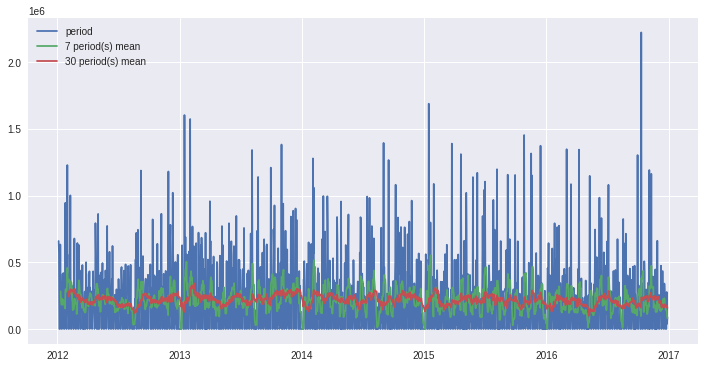

In [414]:
plot_period(temp_df_complete, 7, 30)

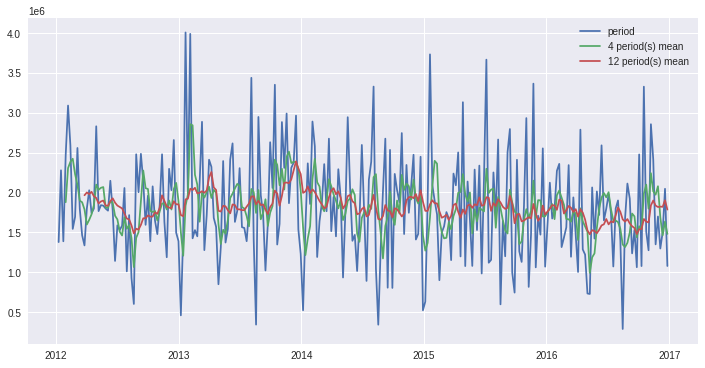

In [415]:
plot_period(temp_df_complete_week, 4, 12)


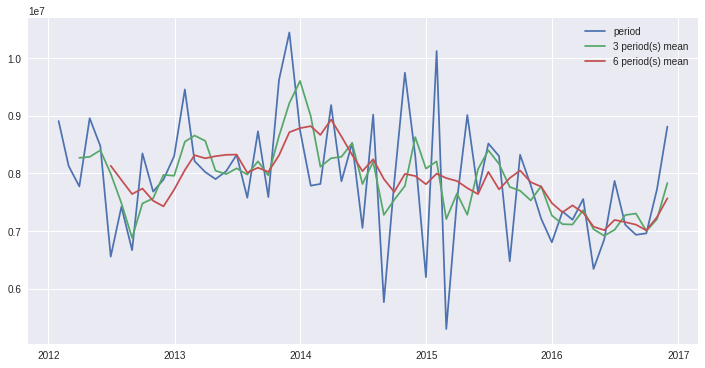

In [416]:
plot_period(temp_df_complete_month, 3, 6)


## Forecasting - ARIMA Model

In [417]:
# test statistics
y = temp_df_complete['Order_Demand']
result = adfuller(y)
result
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -10.7276099795389
p-value: 3.036990324698243e-19


In [418]:
# to find the best pdq by minimum AIC
def order_aic(df, order, sort= 'AIC'):
    order_list= []
    aic_list= []
    bic_list= []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model= ARIMA(df, order= (p,d,q))
            try:
                model_fit = model.fit()
                c_order = f'p{p} d{d} q{q}'
                aic= model_fit.aic
                bic= model_fit.bic
                order_list.append(c_order)
                aic_list.append(aic)
                bic_list.append(bic)
            except:
                pass
            result_df = pd.DataFrame(list(zip(order_list, aic_list)), columns= ['order','AIC'])
            result_df.sort_values(sort, inplace= True)
    return result_df

order_aic(temp_df_complete, [10, 2, 5])


order           AIC
14  p7 d0 q4  50220.632722
16  p8 d0 q4  50226.499536
18  p9 d0 q4  50227.769373
4   p2 d0 q4  50233.044585
8   p4 d0 q4  50234.352537
10  p5 d0 q4  50236.542250
12  p6 d0 q4  50237.277854
6   p3 d0 q4  50240.357901
11  p5 d1 q4  50250.683677
9   p4 d1 q4  50261.591732
7   p3 d1 q4  50263.023891
15  p7 d1 q4  50344.703651
19  p9 d1 q4  50345.472132
17  p8 d1 q4  50380.760492
13  p6 d1 q4  50387.798439
2   p1 d0 q4  50534.383398
0   p0 d0 q4  50536.935717
1   p0 d1 q4  50541.981002
3   p1 d1 q4  50558.901032
5   p2 d1 q4  50565.526529

- Best Model: order (7,0,4)

In [419]:
def ARIMA_forecasting(mydf,colval,split, AR, I, MA):
    #print(split)
    import math
    from statsmodels.tsa.arima.model import ARIMA
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    global y_hat, train, test
    total_size=len(mydf)
    train_size=math.floor(split*total_size) #(70% Dataset)
    train=mydf.head(train_size)
    test=mydf.tail(len(mydf) -train_size)
    y_hat = test.copy()
    model = ARIMA(train[colval], order=(AR,I,MA),seasonal_order=(AR,I,MA,12), freq='D')
    fit1 = model.fit()
    y_hat = test.copy()
    y_hat['ARIMA'] = fit1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    plt.figure(figsize=(20,8))
    plt.plot(train.index, train[colval], label='Train')
    plt.plot(test.index,test[colval], label='Test')
    plt.plot(y_hat.index,y_hat['ARIMA'], label='ARIMA')
    plt.legend(loc='best')
    plt.title("ARIMA Forecast")
    plt.show()
    mse=mean_squared_error(test[colval], y_hat.ARIMA)
    rmse = sqrt(mean_squared_error(test[colval], y_hat.ARIMA))
    return mse, rmse, train, test, fit1, y_hat

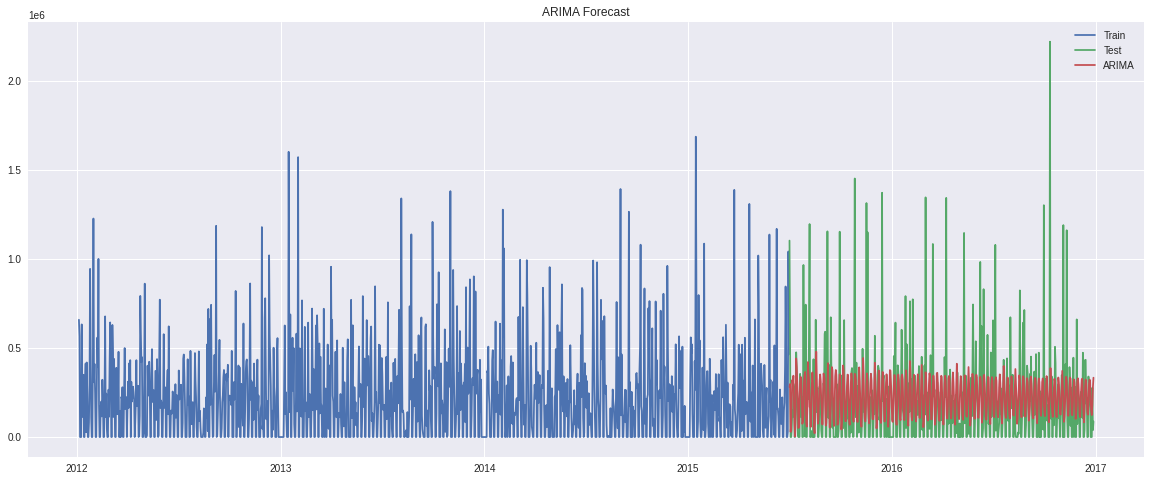

(63039340185.764305, 251076.36325581168,             Order_Demand
 Date                    
 2012-01-05      659000.0
 2012-01-06      567000.0
 2012-01-07           0.0
 2012-01-08           0.0
 2012-01-09           0.0
 ...                  ...
 2015-06-27           0.0
 2015-06-28           0.0
 2015-06-29       31000.0
 2015-06-30     1043000.0
 2015-07-01      465000.0
 
 [1274 rows x 1 columns],             Order_Demand
 Date                    
 2015-07-02     1104000.0
 2015-07-03      584000.0
 2015-07-04           0.0
 2015-07-05           0.0
 2015-07-06       43000.0
 ...                  ...
 2016-12-24           0.0
 2016-12-25           0.0
 2016-12-26      277000.0
 2016-12-27       39000.0
 2016-12-28       87000.0
 
 [546 rows x 1 columns], <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x7f227b823990>,             Order_Demand          ARIMA
 Date                                   
 2015-07-02     1104000.0  281061.078817
 2015-07-03      584000.0  297869.89401

In [420]:
ARIMA_forecasting(temp_df_complete,'Order_Demand',0.7,7,0,4)

In [421]:
y_true= test['Order_Demand'].to_numpy()
y_pred= y_hat['ARIMA'].to_numpy()

In [422]:
print(f'mase: {round(mae(y_true, y_pred), 5)}')
print(f'rmse: {round(rmse(y_true, y_pred), 5)}')
print(f'r2  : {round(r2(y_true, y_pred), 5)}')


mase: 166221.46985
rmse: 251076.36326
r2  : 0.14257


## AUTO ARIMA MODEL

In [423]:
model= pm.auto_arima(temp_df_complete, start_p= 1, start_q= 1, 
                      test= 'adf', max_p= 3, max_q= 3, m= 1, 
                      d= None, seasonal=False, start_P=0, D= 0, 
                      trace= True, error_action= 'ignore', 
                      suppress_warnings= True, stepwise= True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51557.447, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=51080.779, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=51214.433, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=51044.555, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=51000.448, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.94 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=50550.226, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=50565.101, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=50549.822, Time=0.45 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=50570.680, Time=0.73 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=50540.885, Time=1.29 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=50579.506, Time=0.56 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   :

- Best model:  ARIMA(3,0,2)(0,0,0)[0] intercept

In [424]:
auto_arima_order= (3,0,2)
auto_arima_product_1359= ARIMA(train, order= auto_arima_order, freq='D')
auto_arima_model= auto_arima_product_1359.fit()
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Order_Demand   No. Observations:                 1274
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -17551.043
Date:                Thu, 31 Mar 2022   AIC                          35116.087
Time:                        11:23:57   BIC                          35152.136
Sample:                    01-05-2012   HQIC                         35129.626
                         - 07-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.241e+05   6.45e-08   3.48e+12      0.000    2.24e+05    2.24e+05
ar.L1          1.2616      0.032     39.676      0.000       1.199       1.324
ar.L2         -1.0181      0.040    -25.686      0.000      -1.096      -0.940
ar.L3          0.0146      0.032      0.458      0.647      -0.048       0.077
ma.L1         -1.2451      0.017    -74.468      0.000      -1.278      -1.212
ma.L2          1.0000      0.024     41.143      0.000       0.952       1.048
sigma2      6.341e+10   5.43e-13   1.17e+23      0.000    6.34e+10    6.34e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2917.47
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             2.00
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.83e+36. Standard errors may be unstable.
"""

In [425]:
pred_auto_arima= auto_arima_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
pred_auto_arima

2015-07-02    330937.293168
2015-07-03    178996.729735
2015-07-04     61942.773203
2015-07-05     67017.677851
2015-07-06    190385.573338
                  ...      
2016-12-24     63231.423030
2016-12-25     66678.729907
2016-12-26    188674.077325
2016-12-27    337355.319367
2016-12-28    400767.337978
Freq: D, Name: predicted_mean, Length: 546, dtype: float64

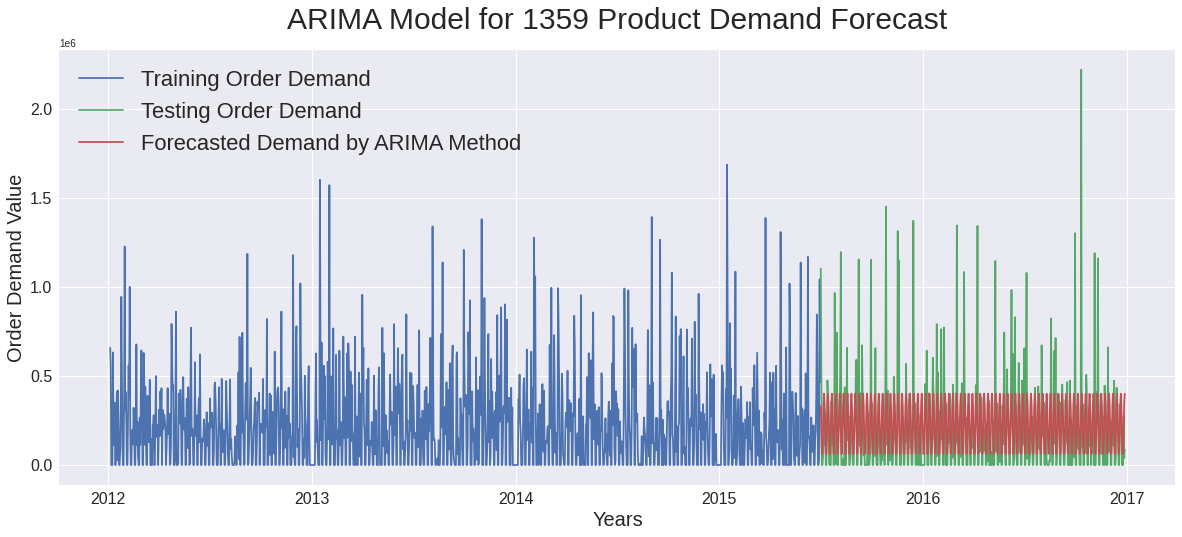

In [426]:
# plot auto arima prediction all data
plt.figure(figsize=(20, 8))
plt.title("ARIMA Model for 1359 Product Demand Forecast", fontsize=30, pad=21)
plt.plot(train, label='Training Order Demand')
plt.plot(test, label='Testing Order Demand')
plt.plot(pred_auto_arima, label='Forecasted Demand by ARIMA Method')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rc('font', **{'size':'22'})
plt.legend(loc="best", prop={'size': 30});
plt.ylabel('Order Demand Value', fontsize= 20)
plt.xlabel('Years', fontsize= 20)
plt.legend(loc="best")
plt.legend(loc="best", prop={'size': 22})

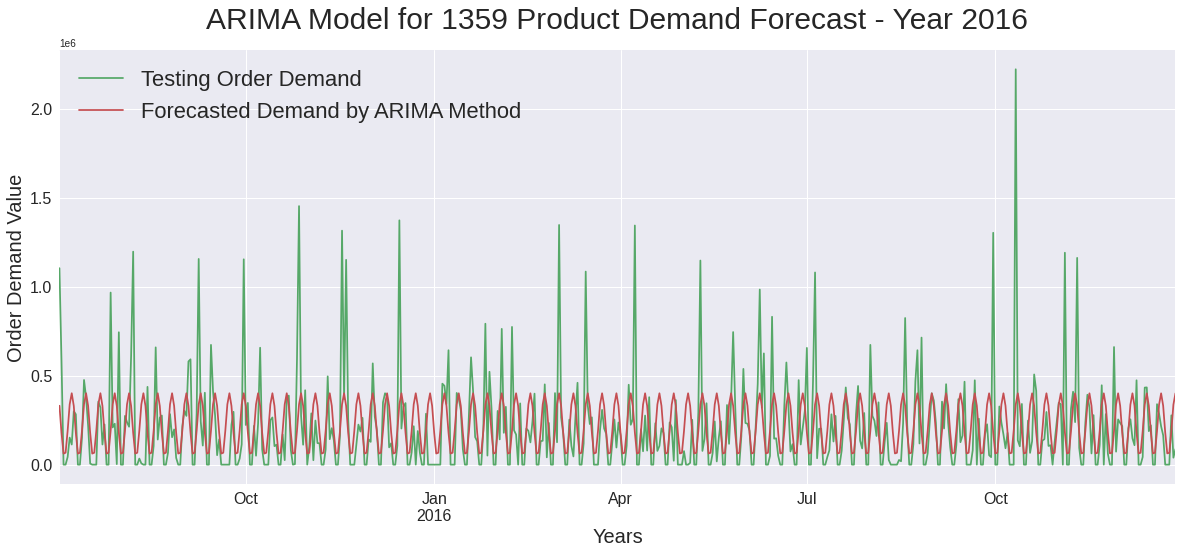

In [427]:
# plot auto arima prediction year 2016
plt.title("ARIMA Model for 1359 Product Demand Forecast - Year 2016", fontsize=30, pad=21)
test['Order_Demand'].plot(figsize=(20,8), color='#56a868', label='Testing Order Demand', legend=True)
pred_auto_arima.plot(label='Forecasted Demand by ARIMA Method', color='#c54e52', legend=True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rc('font', **{'size':'22'})
plt.legend(loc="best", prop={'size': 30});
plt.ylabel('Order Demand Value', fontsize= 20)
plt.xlabel('Years', fontsize= 20)
plt.legend(loc="best")
plt.legend(loc="best", prop={'size': 22});

In [428]:
y_true_auto_arima = test['Order_Demand'].to_numpy()
y_pred_auto_arima = pred_auto_arima.to_numpy()

In [429]:
print(f'mae_auto_arima: {round(mae(y_true_auto_arima, y_pred_auto_arima), 5)}')
print(f'rmse_auto_arima: {round(rmse(y_true_auto_arima, y_pred_auto_arima), 5)}')
print(f'r2_auto_arima  : {round(r2(y_true_auto_arima, y_pred_auto_arima), 5)}')


mae_auto_arima: 163279.98079
rmse_auto_arima: 250012.2348
r2_auto_arima  : 0.14983


# SARIMAX MODEL

In [430]:
# !pip3 install pyramid-arima
#import pmdarima as pm

'''Seasonal - fit stepwise auto-ARIMA
#smodel = pm.auto_arima(temp_df_complete, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=30,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()'''

# it is consuming more RAM.

"Seasonal - fit stepwise auto-ARIMA\n#smodel = pm.auto_arima(temp_df_complete, start_p=1, start_q=1,\n                         test='adf',\n                         max_p=3, max_q=3, m=30,\n                         start_P=0, seasonal=True,\n                         d=None, D=1, trace=True,\n                         error_action='ignore',  \n                         suppress_warnings=True, \n                         stepwise=True)\n\nsmodel.summary()"

In [431]:
# creates the model
import statsmodels.api as sm
auto_sarimax_order = (2,0,2)
auto_sarimax_seasonal_order = (2,1,0,12)
auto_sarimax_product_1359 = sm.tsa.statespace.SARIMAX(train, 
                                                      order=auto_sarimax_order, 
                                                      seasonal_order=auto_sarimax_seasonal_order,
                                                      enforce_stationarity=False,
                                                      enforce_invertibility=False)
auto_sarimax_model = auto_sarimax_product_1359.fit(alpha=0.05)

print(auto_sarimax_model.summary())


                                      SARIMAX Results                                      
Dep. Variable:                        Order_Demand   No. Observations:                 1274
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 12)   Log Likelihood              -17308.112
Date:                             Thu, 31 Mar 2022   AIC                          34630.223
Time:                                     11:24:18   BIC                          34666.061
Sample:                                 01-05-2012   HQIC                         34643.703
                                      - 07-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2454      0.005    272.927      0.000       1.237       1.254
ar.L2         -0.9984      

In [432]:
test.head()

Order_Demand
Date                    
2015-07-02     1104000.0
2015-07-03      584000.0
2015-07-04           0.0
2015-07-05           0.0
2015-07-06       43000.0

In [433]:
test.tail()

Order_Demand
Date                    
2016-12-24           0.0
2016-12-25           0.0
2016-12-26      277000.0
2016-12-27       39000.0
2016-12-28       87000.0

In [434]:
pred_auto_sarimax = auto_sarimax_model.predict('2015-07-02', '2016-12-28', typ='levels')
pred_auto_sarimax


2015-07-02    591123.904118
2015-07-03    453366.496917
2015-07-04    -22236.609236
2015-07-05    -82374.923192
2015-07-06    134871.498063
                  ...      
2016-12-24    348752.341373
2016-12-25     33997.425925
2016-12-26     71696.973920
2016-12-27    279718.637279
2016-12-28    572510.625733
Freq: D, Name: predicted_mean, Length: 546, dtype: float64

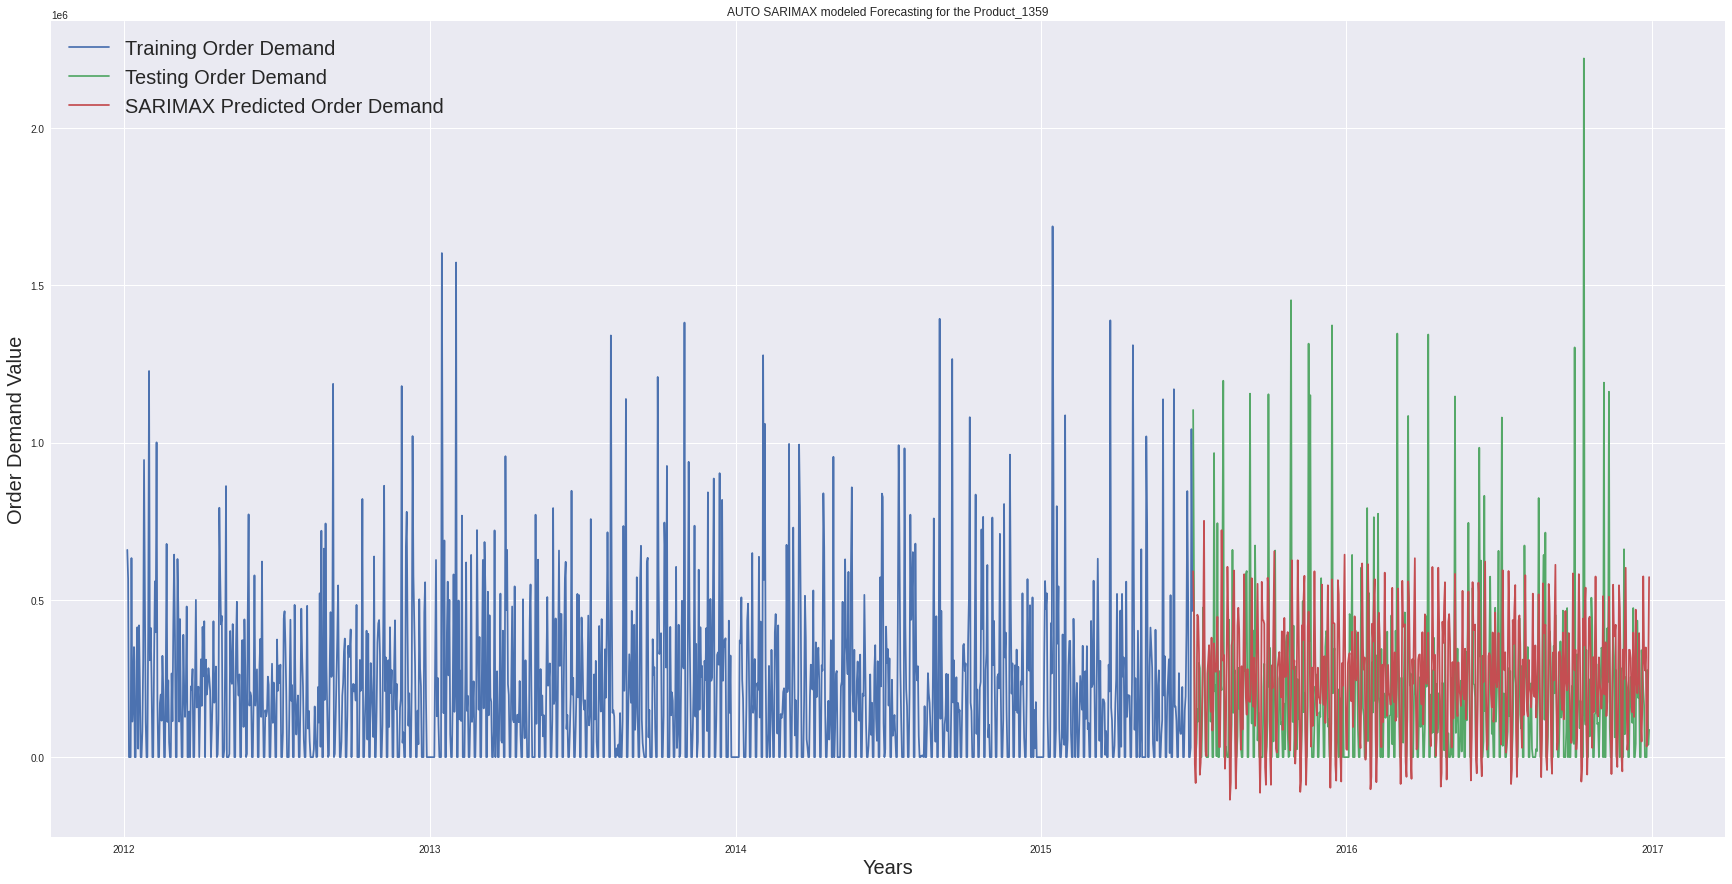

In [435]:
# plot auto sarimax prediction all data
plt.figure(figsize=(30, 15))
plt.title("AUTO SARIMAX modeled Forecasting for the Product_1359")
plt.plot(train, label='Training Order Demand')
plt.plot(test, label='Testing Order Demand')
plt.plot(pred_auto_sarimax, label='SARIMAX Predicted Order Demand')
plt.ylabel('Order Demand Value', fontsize= 20)
plt.xlabel('Years', fontsize= 20)
plt.legend(loc="best", fontsize= 20);


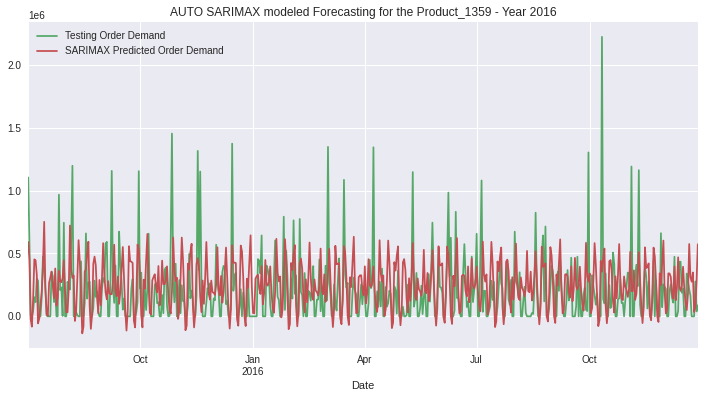

In [436]:
# plot auto sarimax prediction year 2016
plt.title("AUTO SARIMAX modeled Forecasting for the Product_1359 - Year 2016")
test['Order_Demand'].plot(figsize=(12,6), color='#56a868', label='Testing Order Demand', legend=True);
pred_auto_sarimax.plot(label='SARIMAX Predicted Order Demand', color='#c54e52', legend=True);


In [437]:
y_true_auto_sarimax = test['Order_Demand'].to_numpy()
y_pred_auto_sarimax = pred_auto_sarimax.to_numpy()


In [438]:
print(f'mae_auto_sarimax: {round(mae(y_true_auto_sarimax, y_pred_auto_sarimax), 5)}')
print(f'rmse_auto_sarimax: {round(rmse(y_true_auto_sarimax, y_pred_auto_sarimax), 5)}')
print(f'r2_auto_sarimax  : {round(r2(y_true_auto_sarimax, y_pred_auto_sarimax), 5)}')


mae_auto_sarimax: 210783.63916
rmse_auto_sarimax: 286933.77075
r2_auto_sarimax  : -0.11982


## Naive Benchmarking

In [439]:
# Create dataset
values = pd.DataFrame(temp_df_complete)
naive_df= pd.concat([values.shift(365), values], axis=1)
naive_df.columns = ['Naive Forecast Actual-365', 'Actual']
print(naive_df.head(5))
print(naive_df.tail(5))


            Naive Forecast Actual-365    Actual
Date                                           
2012-01-05                        NaN  659000.0
2012-01-06                        NaN  567000.0
2012-01-07                        NaN       0.0
2012-01-08                        NaN       0.0
2012-01-09                        NaN       0.0
            Naive Forecast Actual-365    Actual
Date                                           
2016-12-24                    68000.0       0.0
2016-12-25                        0.0       0.0
2016-12-26                        0.0  277000.0
2016-12-27                   286000.0   39000.0
2016-12-28                        0.0   87000.0


In [440]:
# naive t-365 data modeling
naive_df_until_2015 = naive_df['Actual'].loc[:'2016-01-01']
naive_df_from_2016 = naive_df['Actual'].loc['2016-01-01':]
naive_pred = naive_df['Naive Forecast Actual-365'].loc['2016-01-01':]


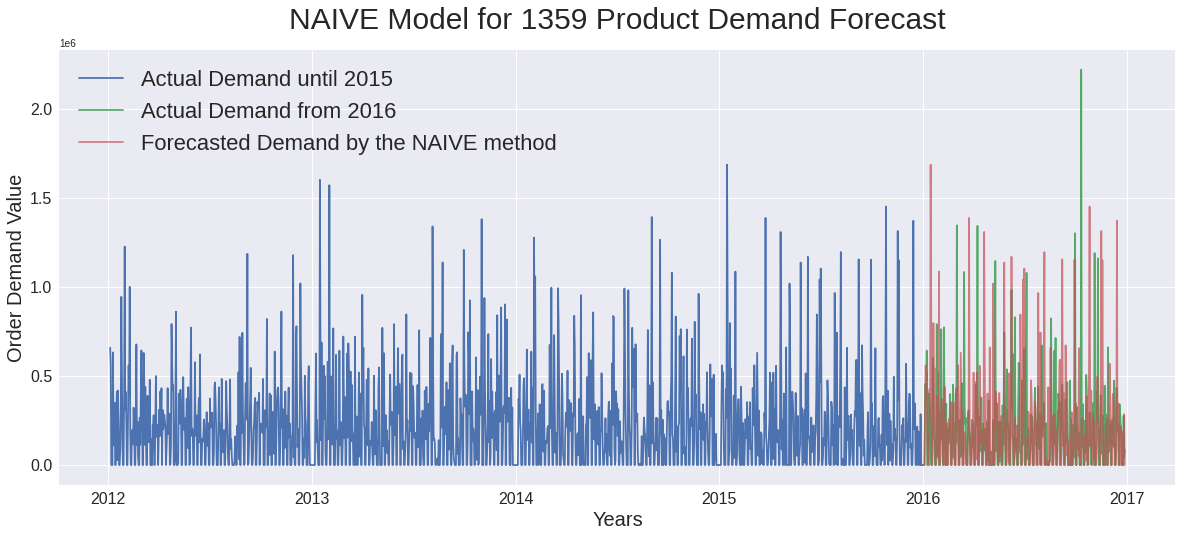

In [441]:
# plot naive prediction all data

plt.figure(figsize=(20, 8))
plt.title("NAIVE Model for 1359 Product Demand Forecast", fontsize=30, pad=21)
plt.plot(naive_df_until_2015, label='Actual Demand until 2015')
plt.plot(naive_df_from_2016, label='Actual Demand from 2016')
plt.plot(naive_pred, label='Forecasted Demand by the NAIVE method', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rc('font', **{'size':'22'})
plt.ylabel('Order Demand Value', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.legend(loc="best", prop={'size': 22});


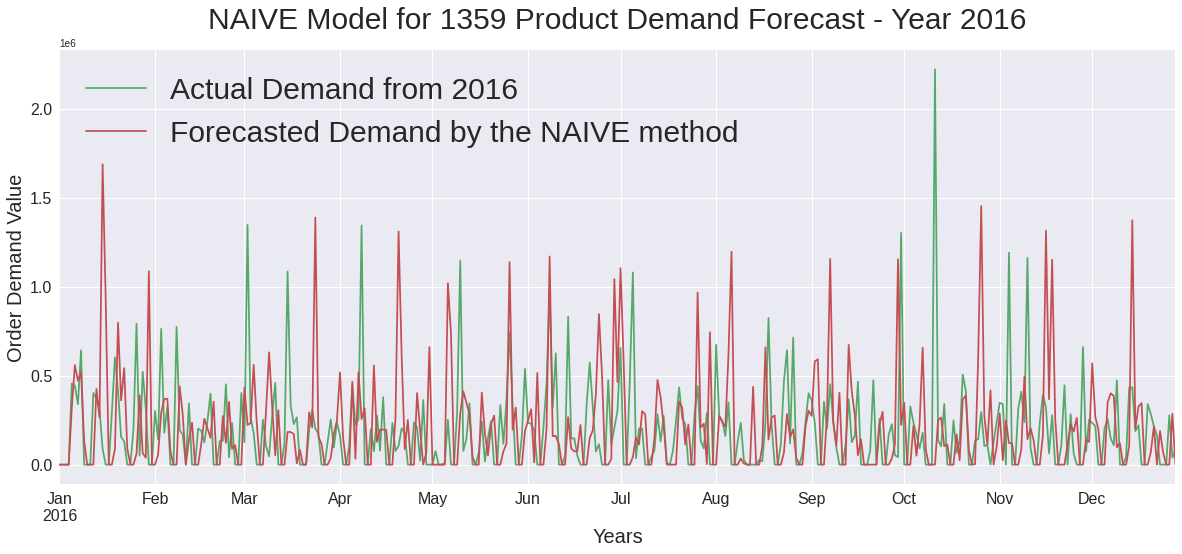

In [442]:
# plot auto NAIVE t-365 prediction year 2016
plt.title("NAIVE Model for 1359 Product Demand Forecast - Year 2016", fontsize=30, pad=21)
naive_df_from_2016.plot(figsize=(20,8), color='#56a868', label='Actual Demand from 2016', legend=True);
naive_pred.plot(label='Forecasted Demand by the NAIVE method', color='#c54e52', legend=True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rc('font', **{'size':'22'})
plt.ylabel('Order Demand Value', fontsize=20)
plt.xlabel('Years', fontsize=20)
plt.legend(loc="best", prop={'size': 30});


In [443]:
y_true_naive = naive_df_from_2016.to_numpy()
y_pred_naive = naive_pred.to_numpy()

In [444]:
print(f'mae_naive: {round(mae(y_true_naive, y_pred_naive), 5)}')
print(f'rmse_naive: {round(rmse(y_true_naive, y_pred_naive), 5)}')
print(f'r2_naive  : {round(r2(y_true_naive, y_pred_naive), 5)}')



mae_naive: 233079.88981
rmse_naive: 369923.11762
r2_naive  : -0.97947


## SMOOTHENING MOVING AVERAGE-3 DAYS

             Order_Demand
Date                     
2012-01-05            NaN
2012-01-06            NaN
2012-01-07  408666.666667
2012-01-08  189000.000000
2012-01-09       0.000000
2012-01-10  211000.000000
2012-01-11  248666.666667
2012-01-12  309666.666667
2012-01-13  215333.333333
2012-01-14  177666.666667


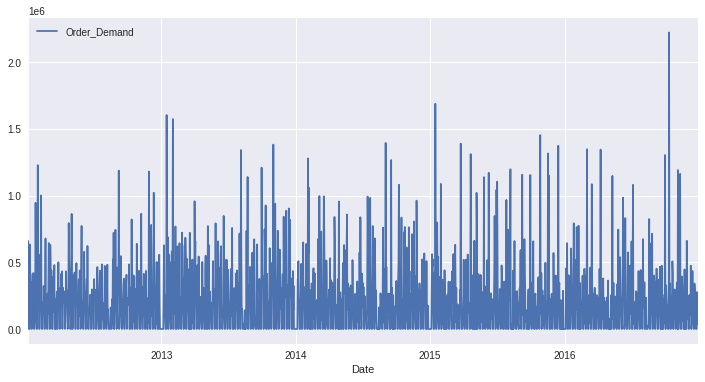

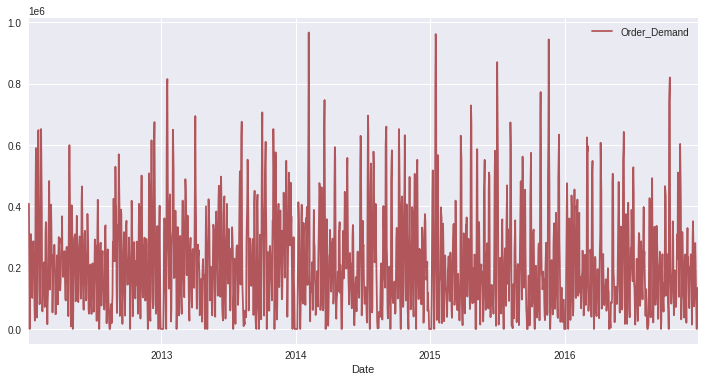

In [445]:
values = pd.DataFrame(temp_df_complete)

# tail-rolling average transform
rolling = values.rolling(window=3)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))

# plot original and transformed dataset
values.plot()
rolling_mean.plot(color='#b1565b')


In [446]:
# smoothing moving average data modeling
sma_until_2015 = values['Order_Demand'].loc[:'2016-01-01']
sma_from_2016 = values['Order_Demand'].loc['2016-01-01':]
sma_pred_3days_mean = rolling_mean['Order_Demand'].loc['2016-01-01':]


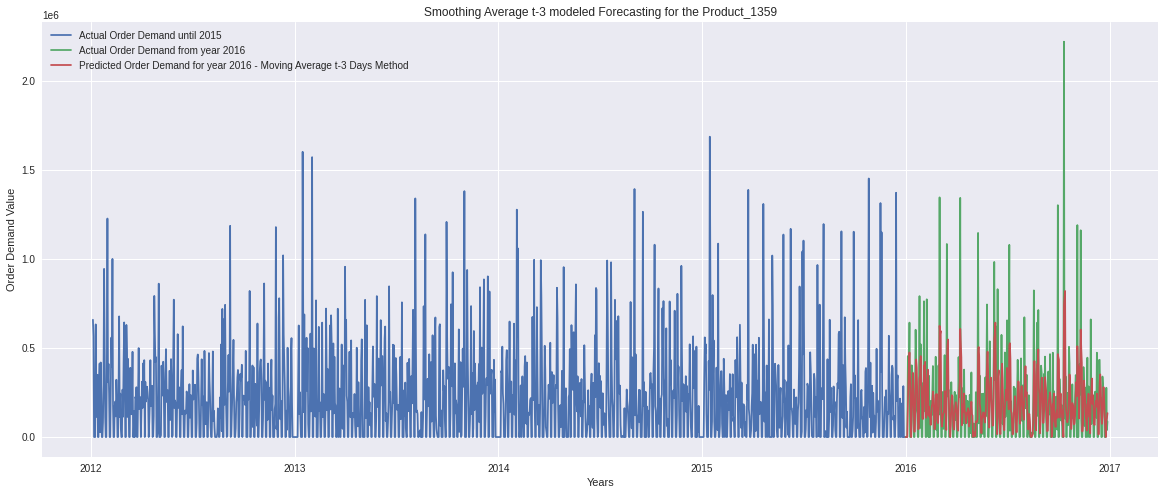

In [447]:
# plot naive t-365 prediction all data
plt.figure(figsize=(20, 8))
plt.title("Smoothing Average t-3 modeled Forecasting for the Product_1359")
plt.plot(sma_until_2015, label='Actual Order Demand until 2015')
plt.plot(sma_from_2016, label='Actual Order Demand from year 2016')
plt.plot(sma_pred_3days_mean, label='Predicted Order Demand for year 2016 - Moving Average t-3 Days Method')
plt.ylabel('Order Demand Value')
plt.xlabel('Years')
plt.legend(loc="best");


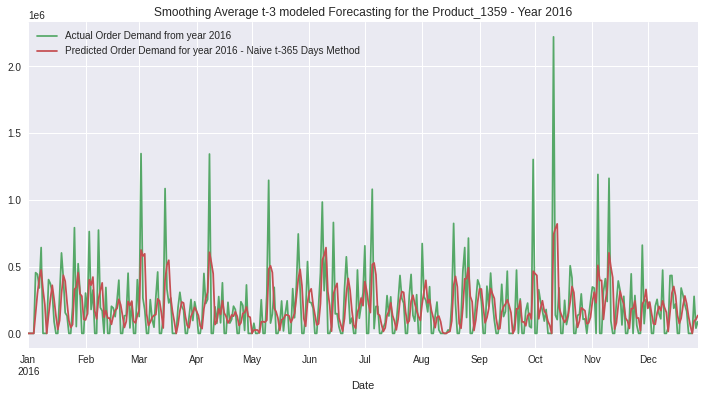

In [448]:
# plot auto NAIVE t-365 prediction year 2016
plt.title("Smoothing Average t-3 modeled Forecasting for the Product_1359 - Year 2016")
sma_from_2016.plot(figsize=(12,6), color='#56a868', label='Actual Order Demand from year 2016', legend=True);
sma_pred_3days_mean.plot(label='Predicted Order Demand for year 2016 - Naive t-365 Days Method', color='#c54e52', legend=True);


In [449]:
y_true_sma = sma_from_2016.to_numpy()
y_pred_sma = sma_pred_3days_mean.to_numpy()

In [450]:
print(f'mae_sma: {round(mae(y_true_sma, y_pred_sma), 5)}')
print(f'rmse_sma: {round(rmse(y_true_sma, y_pred_sma), 5)}')
print(f'r2_sma  : {round(r2(y_true_sma, y_pred_sma), 5)}')

mae_sma: 155751.14784
rmse_sma: 221332.30373
r2_sma  : 0.29138


## Comparing the Models 

In [451]:
comp = pd.DataFrame({'MODEL':['ARIMA', 'AUTO_ARIMA', 'SARIMAX', 'NAIVE_BM', 'SMA_3days'], 
                     'MAE':[round(mae(y_true, y_pred),5), round(mae(y_true_auto_arima, y_pred_auto_arima), 5), round(mae(y_true_auto_sarimax, y_pred_auto_sarimax), 5), round(mae(y_true_naive, y_pred_naive), 5), round(mae(y_true_sma, y_pred_sma), 5)], 
                     'RMSE':[round(rmse(y_true, y_pred), 5), round(rmse(y_true_auto_arima, y_pred_auto_arima), 5), round(rmse(y_true_auto_sarimax, y_pred_auto_sarimax), 5), round(rmse(y_true_naive, y_pred_naive), 5), round(rmse(y_true_sma, y_pred_sma), 5)], 
                     'R2':[round(r2(y_true, y_pred), 5), round(r2(y_true_auto_arima, y_pred_auto_arima), 5), round(r2(y_true_auto_sarimax, y_pred_auto_sarimax), 5), round(r2(y_true_naive, y_pred_naive), 5), round(r2(y_true_sma, y_pred_sma), 5)]})

comp.sort_values(by=['RMSE'], ascending=True)

MODEL           MAE          RMSE       R2
4   SMA_3days  155751.14784  221332.30373  0.29138
1  AUTO_ARIMA  163279.98079  250012.23480  0.14983
0       ARIMA  166221.46985  251076.36326  0.14257
2     SARIMAX  210783.63916  286933.77075 -0.11982
3    NAIVE_BM  233079.88981  369923.11762 -0.97947

## Conclusion:

From this, we can say that the **Smoothening Average Model**(with rolling window= 3 days) is the generalized model for the given dataset.